In [1]:
import warnings
warnings.filterwarnings('ignore')

## Code for figures of "Decomposing the Drivers of Polar Amplification with a Single Column Model" by Matthew Henry, Tim Merlis, Nicholas Lutsko, and Brian Rose

#### Setup an "issue" or email matthew.henry@mail.mcgill.ca for questions

#### Go to http://meteo.mcgill.ca/~mhenry/files/ to get the CMIP6 data (SCM_cmip6.nc), the idealized GCM data (SCM_iGCM_data.tar.gz and unzip), and the aquaplanet kernels (lwclr_q.nc and lwclr_t.nc).

#### `wget http://meteo.mcgill.ca/~mhenry/files/SCM_cmip6.nc` should work to download the file where you want it and `tar xvzf SCM_iGCM_data.tar.gz` to unzip the file.

# Preliminary imports and functions

In [2]:
%load_ext autoreload
%autoreload 2
%precision 2
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from utils_un import ncdf_obj
import matplotlib.cm as cm
import ClimateUtils as clim
import climlab
import netCDF4
import xarray as xr
from netCDF4 import Dataset
from scipy import interpolate

def mean_lat(lat,val):
    
    if(lat.shape[0] != val.shape[0]):
        print("Latitude and value vectors not of same size.")
        return 0
    else :
        # assume lat in degrees
        w = np.cos(lat*np.pi/180)
        return np.sum(val*w)/np.sum(w)

def plot_pole(field_lin, lat, lat_lev):

    lr_lin=np.zeros((field_lin).shape[0],)

    for i in range(field_lin.shape[0]):
        lr_lin[i]=mean_lat(lat[lat>lat_lev],field_lin[i,lat>lat_lev])

    return lr_lin

def plot_eq(field_lin, lat, lat_lev):

    lr_lin=np.zeros((field_lin).shape[0],)
    masks = [lat>-lat_lev,lat<lat_lev]
    mask = masks[0] & masks[1]

    for i in range(field_lin.shape[0]):
        lr_lin[i]=mean_lat(lat[mask],field_lin[i,mask])

    return lr_lin

class ExternalForcing(climlab.process.TimeDependentProcess):
    def __init__(self,**kwargs):
        super(ExternalForcing, self).__init__(**kwargs)
        self.forcing_tendencies = {}
        for var in self.state:
            self.forcing_tendencies[var] = 0. * self.state[var]

    def _compute(self):
        return self.forcing_tendencies

print('If there is an error here make sure "co2 = ncdf_obj(...)" points to the directory of netCDF files you downloaded from http://meteo.mcgill.ca/~mhenry/files/')

co2 = ncdf_obj('./iGCM_data/idealised_moist_AM2rad_albedo/','300ppm','1200ppm')
co2_HS12 = ncdf_obj('./iGCM_data/idealised_moist_AM2rad_albedo/','300ppm','1200ppm_HS12')
co2_HS24 = ncdf_obj('./iGCM_data/idealised_moist_AM2rad_albedo/','300ppm','1200ppm_HS24')

font = {'size'   : 14}

If there is an error here make sure "co2 = ncdf_obj(...)" points to the directory of netCDF files you downloaded from http://meteo.mcgill.ca/~mhenry/files/


# Set up column model

In [3]:
def run_column(atm_input, sh_input, gcm_p, co2_lev=3e-4, insol=175.2, alb=0.54,surf_forc=0):
    
    state = climlab.column_state(lev=gcm_p, num_lat=1, water_depth=1.)
    model = climlab.TimeDependentProcess(state=state)
    
    conv = climlab.convection.ConvectiveAdjustment(state=state, adj_lapse_rate='MALR')
    abs_vmr = climlab.radiation.radiation.default_absorbers(model.Tatm)
    abs_vmr['CO2']=co2_lev
    rad = climlab.radiation.RRTMG(state=state,
                                 specific_humidity=sh_input,
                                 albedo = alb,
                                 insolation = insol,
                                 absorber_vmr = abs_vmr)
    myforcing = ExternalForcing(state=state)
    myforcing.forcing_tendencies['Tatm']=atm_input
    myforcing.forcing_tendencies['Ts']=surf_forc
    model.add_subprocess('Radiation', rad)
    model.add_subprocess('ConvectiveAdjustment', conv)
    model.add_subprocess('advective forcing', myforcing)
    model.integrate_years(1,False)
    return model

def run_column_fixedRH(atm_input, rh_input, gcm_p, co2_lev=3e-4, insol=175.2, alb=0.54,surf_forc=0):
    
    state = climlab.column_state(lev=gcm_p, num_lat=1, water_depth=1.)
    model = climlab.TimeDependentProcess(state=state)
    
    conv = climlab.convection.ConvectiveAdjustment(state=state, adj_lapse_rate='MALR')
    abs_vmr = climlab.radiation.radiation.default_absorbers(model.Tatm)
    abs_vmr['CO2']=co2_lev
    h2o = climlab.radiation.water_vapor.FixedRelativeHumidity(state=model.state)
    h2o.RH_profile = rh_input
    rad = climlab.radiation.RRTMG(state=state,
                                 specific_humidity=h2o.q,
                                 albedo = alb,
                                 insolation = insol,
                                 absorber_vmr = abs_vmr)
    myforcing = ExternalForcing(state=state)
    myforcing.forcing_tendencies['Tatm']=atm_input
    myforcing.forcing_tendencies['Ts']=surf_forc
    model.add_subprocess('Radiation', rad)
    model.add_subprocess('ConvectiveAdjustment', conv)
    model.add_subprocess('advective forcing', myforcing)
    model.add_subprocess('WaterVapor', h2o)
    model.integrate_years(1,False)
    return model

In [4]:
def run_column_fixedSW(atm_input, sh_input, gcm_p, co2_lev=3e-4, insol=175.2, alb=0.54,surf_forc=0):
    
    state = climlab.column_state(lev=gcm_p, num_lat=1, water_depth=1.)
    model = climlab.TimeDependentProcess(state=state)
    
    conv = climlab.convection.ConvectiveAdjustment(state=state, adj_lapse_rate='MALR')
    abs_vmr = climlab.radiation.radiation.default_absorbers(model.Tatm)
    abs_vmr['CO2']=co2_lev
    rad = climlab.radiation.RRTMG_LW(state=state,
                                 specific_humidity=sh_input,
                                 absorber_vmr = abs_vmr)
    myforcing = ExternalForcing(state=state)
    myforcing.forcing_tendencies['Tatm']=atm_input
    myforcing.forcing_tendencies['Ts']=surf_forc
    model.add_subprocess('Radiation', rad)
    model.add_subprocess('ConvectiveAdjustment', conv)
    model.add_subprocess('advective forcing', myforcing)
    model.integrate_years(1,False)
    return model

def run_column_fixedRH_fixedSW(atm_input, rh_input, gcm_p, co2_lev=3e-4, insol=175.2, alb=0.54,surf_forc=0):
    
    state = climlab.column_state(lev=gcm_p, num_lat=1, water_depth=1.)
    model = climlab.TimeDependentProcess(state=state)
    
    conv = climlab.convection.ConvectiveAdjustment(state=state, adj_lapse_rate='MALR')
    abs_vmr = climlab.radiation.radiation.default_absorbers(model.Tatm)
    abs_vmr['CO2']=co2_lev
    h2o = climlab.radiation.water_vapor.FixedRelativeHumidity(state=model.state)
    h2o.RH_profile = rh_input
    rad = climlab.radiation.RRTMG_LW(state=state,
                                 specific_humidity=h2o.q,
                                 absorber_vmr = abs_vmr)
    myforcing = ExternalForcing(state=state)
    myforcing.forcing_tendencies['Tatm']=atm_input
    myforcing.forcing_tendencies['Ts']=surf_forc
    model.add_subprocess('Radiation', rad)
    model.add_subprocess('ConvectiveAdjustment', conv)
    model.add_subprocess('advective forcing', myforcing)
    model.add_subprocess('WaterVapor', h2o)
    model.integrate_years(1,False)
    return model

# Get relevant GCM data for column models

In [5]:
class gcm_data:
    
    def __init__(self,ncdf_name, lat_pole, lat_eq):
        masks = [ncdf_name.lat_>-lat_eq,ncdf_name.lat_<lat_eq]
        mask = masks[0] & masks[1]
        self.p_pole = plot_pole(ncdf_name.f_lin.variables['p_full'][:],ncdf_name.lat_,lat_pole)/100
        self.p_trop = plot_pole(ncdf_name.f_lin.variables['p_full'][:],ncdf_name.lat_,lat_eq)/100
        self.dt_adv_300_p = plot_pole(np.mean(np.mean(ncdf_name.s_lin.variables['dt_tg_advection'][:],0),2),ncdf_name.lat_,lat_pole)
        self.dt_adv_300_t = plot_eq(np.mean(np.mean(ncdf_name.s_lin.variables['dt_tg_advection'][:],0),2),ncdf_name.lat_,lat_eq)
        self.dt_cond_300_p = plot_pole(np.mean(np.mean(ncdf_name.s_lin.variables['dt_tg_condensation'][:],0),2),ncdf_name.lat_,lat_pole)
        self.dt_cond_300_t = plot_eq(np.mean(np.mean(ncdf_name.s_lin.variables['dt_tg_condensation'][:],0),2),ncdf_name.lat_,lat_eq)
        self.dt_conv_300_p = plot_pole(np.mean(np.mean(ncdf_name.s_lin.variables['dt_tg_convection'][:],0),2),ncdf_name.lat_,lat_pole)
        self.dt_conv_300_t = plot_eq(np.mean(np.mean(ncdf_name.s_lin.variables['dt_tg_convection'][:],0),2),ncdf_name.lat_,lat_eq)
        self.dt_diff_300_p = plot_pole(np.mean(np.mean(ncdf_name.s_lin.variables['dt_tg_diffusion'][:],0),2),ncdf_name.lat_,lat_pole)
        self.dt_diff_300_t = plot_eq(np.mean(np.mean(ncdf_name.s_lin.variables['dt_tg_diffusion'][:],0),2),ncdf_name.lat_,lat_eq)
        self.dt_sw_300_p = plot_pole(np.mean(np.mean(ncdf_name.s_lin.variables['tdt_sw'][:],0),2),ncdf_name.lat_,lat_pole)
        self.dt_sw_300_t = plot_eq(np.mean(np.mean(ncdf_name.s_lin.variables['tdt_sw'][:],0),2),ncdf_name.lat_,lat_eq)
        self.dt_lw_300_p = plot_pole(np.mean(np.mean(ncdf_name.s_lin.variables['tdt_lw'][:],0),2),ncdf_name.lat_,lat_pole)
        self.dt_lw_300_t = plot_eq(np.mean(np.mean(ncdf_name.s_lin.variables['tdt_lw'][:],0),2),ncdf_name.lat_,lat_eq)
        self.sh_300_p = plot_pole(ncdf_name.q_lin,ncdf_name.lat_,lat_pole)
        self.sh_300_t = plot_eq(ncdf_name.q_lin,ncdf_name.lat_,lat_eq)
        self.rh_300_p = plot_pole(ncdf_name.rhum_lin,ncdf_name.lat_,lat_pole)
        self.rh_300_t = plot_eq(ncdf_name.rhum_lin,ncdf_name.lat_,lat_eq)
        self.temp_300_p = plot_pole(ncdf_name.temp_lin,ncdf_name.lat_,lat_pole)
        self.temp_300_t = plot_eq(ncdf_name.temp_lin,ncdf_name.lat_,lat_eq)
        self.ts_300_p = mean_lat(ncdf_name.lat_[ncdf_name.lat_>lat_pole],ncdf_name.sat_lin[ncdf_name.lat_>lat_pole])
        self.ts_300_t = mean_lat(ncdf_name.lat_[mask],ncdf_name.sat_lin[mask])
        
        self.dt_adv_1200_p = plot_pole(np.mean(np.mean(ncdf_name.s_lin_14xCO2.variables['dt_tg_advection'][:],0),2),ncdf_name.lat_,lat_pole)
        self.dt_adv_1200_t = plot_eq(np.mean(np.mean(ncdf_name.s_lin_14xCO2.variables['dt_tg_advection'][:],0),2),ncdf_name.lat_,lat_eq)
        self.dt_cond_1200_p = plot_pole(np.mean(np.mean(ncdf_name.s_lin_14xCO2.variables['dt_tg_condensation'][:],0),2),ncdf_name.lat_,lat_pole)
        self.dt_cond_1200_t = plot_eq(np.mean(np.mean(ncdf_name.s_lin_14xCO2.variables['dt_tg_condensation'][:],0),2),ncdf_name.lat_,lat_eq)
        self.dt_conv_1200_p = plot_pole(np.mean(np.mean(ncdf_name.s_lin_14xCO2.variables['dt_tg_convection'][:],0),2),ncdf_name.lat_,lat_pole)
        self.dt_conv_1200_t = plot_eq(np.mean(np.mean(ncdf_name.s_lin_14xCO2.variables['dt_tg_convection'][:],0),2),ncdf_name.lat_,lat_eq)
        self.dt_diff_1200_p = plot_pole(np.mean(np.mean(ncdf_name.s_lin_14xCO2.variables['dt_tg_diffusion'][:],0),2),ncdf_name.lat_,lat_pole)
        self.dt_diff_1200_t = plot_eq(np.mean(np.mean(ncdf_name.s_lin_14xCO2.variables['dt_tg_diffusion'][:],0),2),ncdf_name.lat_,lat_eq)
        self.dt_sw_1200_p = plot_pole(np.mean(np.mean(ncdf_name.s_lin_14xCO2.variables['tdt_sw'][:],0),2),ncdf_name.lat_,lat_pole)
        self.dt_sw_1200_t = plot_eq(np.mean(np.mean(ncdf_name.s_lin_14xCO2.variables['tdt_sw'][:],0),2),ncdf_name.lat_,lat_eq)
        self.dt_lw_1200_p = plot_pole(np.mean(np.mean(ncdf_name.s_lin_14xCO2.variables['tdt_lw'][:],0),2),ncdf_name.lat_,lat_pole)
        self.dt_lw_1200_t = plot_eq(np.mean(np.mean(ncdf_name.s_lin_14xCO2.variables['tdt_lw'][:],0),2),ncdf_name.lat_,lat_eq)
        self.sh_1200_p = plot_pole(ncdf_name.q_lin_14xCO2,ncdf_name.lat_,lat_pole)
        self.sh_1200_t = plot_eq(ncdf_name.q_lin_14xCO2,ncdf_name.lat_,lat_eq)
        self.rh_1200_p = plot_pole(ncdf_name.rhum_lin_14xCO2,ncdf_name.lat_,lat_pole)
        self.rh_1200_t = plot_eq(ncdf_name.rhum_lin_14xCO2,ncdf_name.lat_,lat_eq)
        self.temp_1200_p = plot_pole(ncdf_name.temp_lin_14xCO2,ncdf_name.lat_,lat_pole)
        self.temp_1200_t = plot_eq(ncdf_name.temp_lin_14xCO2,ncdf_name.lat_,lat_eq)
        self.ts_1200_p = mean_lat(ncdf_name.lat_[ncdf_name.lat_>lat_pole],ncdf_name.sat_lin_14xCO2[ncdf_name.lat_>lat_pole])
        self.ts_1200_t = mean_lat(ncdf_name.lat_[mask],ncdf_name.sat_lin_14xCO2[mask])

co2_data = gcm_data(co2,80,10)
HS12_data = gcm_data(co2_HS12,80,10)
HS24_data = gcm_data(co2_HS24,80,10)

# Surface temperature and latent heat fluxes not included in SCM --> add as a surface heat source.

In [6]:
def print_GCM_surf_values(ncf, lat_trop=10, lat_pole=80):
    print("Pole control")
    swsfc_net = np.mean(np.mean(ncf.s_lin.variables['swsfc'][:],0),1)
    sw_surf = mean_lat(ncf.lat_[ncf.lat_>lat_pole],swsfc_net[ncf.lat_>lat_pole])
    lwsfc_net = np.mean(np.mean(ncf.s_lin.variables['lwsfc'][:],0),1)
    lw_surf = mean_lat(ncf.lat_[ncf.lat_>lat_pole],lwsfc_net[ncf.lat_>lat_pole])
    flux_t = np.mean(np.mean(ncf.s_lin.variables['flux_t'][:],0),1)
    flux_t = mean_lat(ncf.lat_[ncf.lat_>lat_pole],flux_t[ncf.lat_>lat_pole])
    flux_lhe = np.mean(np.mean(ncf.s_lin.variables['flux_lhe'][:],0),1)
    flux_lhe = mean_lat(ncf.lat_[ncf.lat_>lat_pole],flux_lhe[ncf.lat_>lat_pole])
    print("Net LW : "+ str(lw_surf))
    print("Net SW : "+ str(sw_surf))
    print("Difference : "+str(lw_surf-sw_surf))
    print("Flux t : "+ str(flux_t))
    print("Flux lhe : "+ str(flux_lhe))
    
    print("Tropics Control")
    masks = [ncf.lat_>-lat_trop,ncf.lat_<lat_trop]
    trop_mask = masks[0] & masks[1]
    swsfc_net = np.mean(np.mean(ncf.s_lin.variables['swsfc'][:],0),1)
    sw_surf = mean_lat(ncf.lat_[trop_mask],swsfc_net[trop_mask])
    lwsfc_net = np.mean(np.mean(ncf.s_lin.variables['lwsfc'][:],0),1)
    lw_surf = mean_lat(ncf.lat_[trop_mask],lwsfc_net[trop_mask])
    flux_t = np.mean(np.mean(ncf.s_lin.variables['flux_t'][:],0),1)
    flux_t = mean_lat(ncf.lat_[trop_mask],flux_t[trop_mask])
    flux_lhe = np.mean(np.mean(ncf.s_lin.variables['flux_lhe'][:],0),1)
    flux_lhe = mean_lat(ncf.lat_[trop_mask],flux_lhe[trop_mask])
    print("Net LW : "+ str(lw_surf))
    print("Net SW : "+ str(sw_surf))
    print("Difference : "+str(lw_surf-sw_surf))
    print("Flux t : "+ str(flux_t))
    print("Flux lhe : "+ str(flux_lhe))
    
print("No Qs")
print_GCM_surf_values(co2)

No Qs
Pole control
Net LW : 73.94978614861546
Net SW : 57.787681939901375
Difference : 16.162104208714084
Flux t : -15.772798809283428
Flux lhe : -0.4178640478381784
Tropics Control
Net LW : 88.65435870491895
Net SW : 243.86414935006076
Difference : -155.20979064514182
Flux t : 13.685867702408732
Flux lhe : 141.6880455932611


# High latitudes: surface forcing = LW-SW i.e. SH+LH+Qs + bias in SW (10 W/m2)
# Tropics: surface forcing = bias in SW (30 W/m2)

# Print how much TOA shortwave and albedo is needed for each experiment from GCM

In [7]:
def print_GCM_SW_values(ncf, lat_trop=10, lat_pole=80):
    masks = [ncf.lat_>-lat_trop,ncf.lat_<lat_trop]
    trop_mask = masks[0] & masks[1]
    albedo = 0.22 + 0.4*(ncf.lat_/90)**2
    print("Tropical albedo = "+str(mean_lat(ncf.lat_[trop_mask],albedo[trop_mask])))
    print("Polar albedo = "+str(mean_lat(ncf.lat_[ncf.lat_>=lat_pole],albedo[ncf.lat_>=lat_pole])))
    
    swtoa_dn = np.mean(np.mean(ncf.s_lin.variables['swdn_toa'][:],0),1)
    
    print("TOA SW down (insol) in tropics : "+ str(mean_lat(ncf.lat_[trop_mask],swtoa_dn[trop_mask])))
    print("TOA SW down (insol) in high lat : "+ str(mean_lat(ncf.lat_[ncf.lat_>=lat_pole],swtoa_dn[ncf.lat_>=lat_pole])))
    
    
print("Same for all simulations")
print_GCM_SW_values(co2)

Same for all simulations
Tropical albedo = 0.22200937260852083
Polar albedo = 0.5690354129082634
TOA SW down (insol) in tropics : 414.46729076797084
TOA SW down (insol) in high lat : 175.1170079821525


### GCM's surface energy budget : net SW + net LW + SHF + LHF + Qs = 0
### SCM's surface energy budget : net SW + net LW + convection + surface forcing = 0
### Surface forcing (surf_forc) accounts for difference in absorbed shortwave at the surface (even if insolation and surface albedo are the same), surface sensible and latent heat fluxes minus convective fluxes, and Qs (0, 12, or 24 W/m2 at high latitudes).

# Run fixed RH column models for high latitudes (p) and tropics (t)

In [8]:
model_p_ctl_RH = run_column_fixedRH(co2_data.dt_adv_300_p+co2_data.dt_cond_300_p+co2_data.dt_diff_300_p, co2_data.rh_300_p, co2_data.p_pole, co2_lev=3e-4, insol=175.1, alb=0.57,surf_forc=26.2/climlab.utils.heat_capacity.ocean(1))
model_p_co2_RH = run_column_fixedRH(co2_data.dt_adv_300_p+co2_data.dt_cond_300_p+co2_data.dt_diff_300_p, co2_data.rh_300_p, co2_data.p_pole, co2_lev=12e-4, insol=175.1, alb=0.57,surf_forc=26.2/climlab.utils.heat_capacity.ocean(1))
model_p_full_RH = run_column_fixedRH(co2_data.dt_adv_1200_p+co2_data.dt_cond_1200_p+co2_data.dt_diff_1200_p, co2_data.rh_300_p, co2_data.p_pole, co2_lev=12e-4, insol=175.1, alb=0.57,surf_forc=26.2/climlab.utils.heat_capacity.ocean(1))

model_p_co2_RH_HS12 = run_column_fixedRH(HS12_data.dt_adv_300_p+HS12_data.dt_cond_300_p+HS12_data.dt_diff_300_p, HS12_data.rh_300_p, HS12_data.p_pole, co2_lev=12e-4, insol=175.1, alb=0.57,surf_forc=34.5/climlab.utils.heat_capacity.ocean(1))
model_p_full_RH_HS12 = run_column_fixedRH(HS12_data.dt_adv_1200_p+HS12_data.dt_cond_1200_p+HS12_data.dt_diff_1200_p, HS12_data.rh_300_p, HS12_data.p_pole, co2_lev=12e-4, insol=175.1, alb=0.57,surf_forc=34.5/climlab.utils.heat_capacity.ocean(1))

model_p_co2_RH_HS24 = run_column_fixedRH(HS24_data.dt_adv_300_p+HS24_data.dt_cond_300_p+HS24_data.dt_diff_300_p, HS24_data.rh_300_p, HS24_data.p_pole, co2_lev=12e-4, insol=175.1, alb=0.57,surf_forc=40.5/climlab.utils.heat_capacity.ocean(1))
model_p_full_RH_HS24 = run_column_fixedRH(HS24_data.dt_adv_1200_p+HS24_data.dt_cond_1200_p+HS24_data.dt_diff_1200_p, HS24_data.rh_300_p, HS24_data.p_pole, co2_lev=12e-4, insol=175.1, alb=0.57,surf_forc=40.5/climlab.utils.heat_capacity.ocean(1))

model_t_ctl_RH = run_column_fixedRH(co2_data.dt_adv_300_t+co2_data.dt_cond_300_t+co2_data.dt_diff_300_t, co2_data.rh_300_t, co2_data.p_trop, co2_lev=3e-4, insol=415, alb=0.22,surf_forc=30/climlab.utils.heat_capacity.ocean(1))
model_t_co2_RH = run_column_fixedRH(co2_data.dt_adv_300_t+co2_data.dt_cond_300_t+co2_data.dt_diff_300_t, co2_data.rh_300_t, co2_data.p_trop, co2_lev=12e-4, insol=415, alb=0.22,surf_forc=30/climlab.utils.heat_capacity.ocean(1))
model_t_full_RH = run_column_fixedRH(co2_data.dt_adv_1200_t+co2_data.dt_cond_1200_t+co2_data.dt_diff_1200_t, co2_data.rh_300_t, co2_data.p_trop, co2_lev=12e-4, insol=415, alb=0.22,surf_forc=30/climlab.utils.heat_capacity.ocean(1))

model_t_co2_RH_HS12 = run_column_fixedRH(HS12_data.dt_adv_300_t+HS12_data.dt_cond_300_t+HS12_data.dt_diff_300_t, HS12_data.rh_300_t, HS12_data.p_trop, co2_lev=12e-4, insol=415, alb=0.22,surf_forc=30/climlab.utils.heat_capacity.ocean(1))
model_t_full_RH_HS12 = run_column_fixedRH(HS12_data.dt_adv_1200_t+HS12_data.dt_cond_1200_t+HS12_data.dt_diff_1200_t, HS12_data.rh_300_t, HS12_data.p_trop, co2_lev=12e-4, insol=415, alb=0.22,surf_forc=30/climlab.utils.heat_capacity.ocean(1))

model_t_co2_RH_HS24 = run_column_fixedRH(HS24_data.dt_adv_300_t+HS24_data.dt_cond_300_t+HS24_data.dt_diff_300_t, HS24_data.rh_300_t, HS24_data.p_trop, co2_lev=12e-4, insol=415, alb=0.22,surf_forc=30/climlab.utils.heat_capacity.ocean(1))
model_t_full_RH_HS24 = run_column_fixedRH(HS24_data.dt_adv_1200_t+HS24_data.dt_cond_1200_t+HS24_data.dt_diff_1200_t, HS24_data.rh_300_t, HS24_data.p_trop, co2_lev=12e-4, insol=415, alb=0.22,surf_forc=30/climlab.utils.heat_capacity.ocean(1))

Opened data from /home/links/mh920/.conda/envs/anal_env/lib/python3.6/site-packages/climlab/radiation/data/ozone/apeozone_cam3_5_54.nc
Opened data from /home/links/mh920/.conda/envs/anal_env/lib/python3.6/site-packages/climlab/radiation/data/ozone/apeozone_cam3_5_54.nc
Opened data from /home/links/mh920/.conda/envs/anal_env/lib/python3.6/site-packages/climlab/radiation/data/ozone/apeozone_cam3_5_54.nc
Opened data from /home/links/mh920/.conda/envs/anal_env/lib/python3.6/site-packages/climlab/radiation/data/ozone/apeozone_cam3_5_54.nc
Opened data from /home/links/mh920/.conda/envs/anal_env/lib/python3.6/site-packages/climlab/radiation/data/ozone/apeozone_cam3_5_54.nc
Opened data from /home/links/mh920/.conda/envs/anal_env/lib/python3.6/site-packages/climlab/radiation/data/ozone/apeozone_cam3_5_54.nc
Opened data from /home/links/mh920/.conda/envs/anal_env/lib/python3.6/site-packages/climlab/radiation/data/ozone/apeozone_cam3_5_54.nc
Opened data from /home/links/mh920/.conda/envs/anal_env

In [9]:
model_p_ctl = run_column(co2_data.dt_adv_300_p+co2_data.dt_cond_300_p+co2_data.dt_diff_300_p, co2_data.sh_300_p, co2_data.p_pole, co2_lev=3e-4, insol=175.1, alb=0.57,surf_forc=26.2/climlab.utils.heat_capacity.ocean(1))
model_p_co2 = run_column(co2_data.dt_adv_300_p+co2_data.dt_cond_300_p+co2_data.dt_diff_300_p, co2_data.sh_300_p, co2_data.p_pole, co2_lev=12e-4, insol=175.1, alb=0.57,surf_forc=26.2/climlab.utils.heat_capacity.ocean(1))
model_p_sh = run_column(co2_data.dt_adv_300_p+co2_data.dt_cond_300_p+co2_data.dt_diff_300_p, co2_data.sh_1200_p, co2_data.p_pole, co2_lev=3e-4,insol=175.1, alb=0.57,surf_forc=26.2/climlab.utils.heat_capacity.ocean(1))
model_p_sh_local = run_column(co2_data.dt_adv_300_p+co2_data.dt_cond_300_p+co2_data.dt_diff_300_p, co2_data.sh_300_p+(model_p_co2_RH.q-model_p_ctl_RH.q), co2_data.p_pole, co2_lev=3e-4, insol=175.1, alb=0.57,surf_forc=26.2/climlab.utils.heat_capacity.ocean(1))
model_p_dry = run_column(co2_data.dt_adv_1200_p+co2_data.dt_cond_300_p+co2_data.dt_diff_300_p, co2_data.sh_300_p, co2_data.p_pole, co2_lev=3e-4, insol=175.1, alb=0.57,surf_forc=26.2/climlab.utils.heat_capacity.ocean(1))
model_p_moist = run_column(co2_data.dt_adv_300_p+co2_data.dt_cond_1200_p+co2_data.dt_diff_300_p, co2_data.sh_300_p, co2_data.p_pole, co2_lev=3e-4, insol=175.1, alb=0.57,surf_forc=26.2/climlab.utils.heat_capacity.ocean(1))
model_p_diff = run_column(co2_data.dt_adv_300_p+co2_data.dt_cond_300_p+co2_data.dt_diff_1200_p, co2_data.sh_300_p, co2_data.p_pole, co2_lev=3e-4, insol=175.1, alb=0.57,surf_forc=26.2/climlab.utils.heat_capacity.ocean(1))
model_p_full = run_column(co2_data.dt_adv_1200_p+co2_data.dt_cond_1200_p+co2_data.dt_diff_1200_p, co2_data.sh_1200_p, co2_data.p_pole, co2_lev=12e-4, insol=175.1, alb=0.57,surf_forc=26.2/climlab.utils.heat_capacity.ocean(1))

model_p_qs_HS12 = run_column(HS12_data.dt_adv_300_p+HS12_data.dt_cond_300_p+HS12_data.dt_diff_300_p, HS12_data.sh_300_p, HS12_data.p_pole, co2_lev=3e-4, insol=175.1, alb=0.57,surf_forc=34.5/climlab.utils.heat_capacity.ocean(1))
model_p_co2_HS12 = run_column(HS12_data.dt_adv_300_p+HS12_data.dt_cond_300_p+HS12_data.dt_diff_300_p, HS12_data.sh_300_p, HS12_data.p_pole, co2_lev=12e-4, insol=175.1, alb=0.57,surf_forc=26.2/climlab.utils.heat_capacity.ocean(1))
model_p_sh_HS12 = run_column(HS12_data.dt_adv_300_p+HS12_data.dt_cond_300_p+HS12_data.dt_diff_300_p, HS12_data.sh_1200_p, HS12_data.p_pole, co2_lev=3e-4, insol=175.1, alb=0.57,surf_forc=26.2/climlab.utils.heat_capacity.ocean(1))
model_p_sh_local_HS12 = run_column(co2_data.dt_adv_300_p+co2_data.dt_cond_300_p+co2_data.dt_diff_300_p, HS12_data.sh_300_p+(model_p_co2_RH_HS12.q-model_p_ctl_RH.q), co2_data.p_pole, co2_lev=3e-4, insol=175.1, alb=0.57,surf_forc=26.2/climlab.utils.heat_capacity.ocean(1))
model_p_dry_HS12 = run_column(HS12_data.dt_adv_1200_p+HS12_data.dt_cond_300_p+HS12_data.dt_diff_300_p, HS12_data.sh_300_p, HS12_data.p_pole, co2_lev=3e-4, insol=175.1, alb=0.57,surf_forc=26.2/climlab.utils.heat_capacity.ocean(1))
model_p_moist_HS12 = run_column(HS12_data.dt_adv_300_p+HS12_data.dt_cond_1200_p+HS12_data.dt_diff_300_p, HS12_data.sh_300_p, HS12_data.p_pole, co2_lev=3e-4, insol=175.1, alb=0.57,surf_forc=26.2/climlab.utils.heat_capacity.ocean(1))
model_p_diff_HS12 = run_column(HS12_data.dt_adv_300_p+HS12_data.dt_cond_300_p+HS12_data.dt_diff_1200_p, HS12_data.sh_300_p, HS12_data.p_pole, co2_lev=3e-4, insol=175.1, alb=0.57,surf_forc=26.2/climlab.utils.heat_capacity.ocean(1))
model_p_full_HS12 = run_column(HS12_data.dt_adv_1200_p+HS12_data.dt_cond_1200_p+HS12_data.dt_diff_1200_p, HS12_data.sh_1200_p, HS12_data.p_pole, co2_lev=12e-4, insol=175.1, alb=0.57,surf_forc=34.5/climlab.utils.heat_capacity.ocean(1))

model_p_qs_HS24 = run_column(HS24_data.dt_adv_300_p+HS24_data.dt_cond_300_p+HS24_data.dt_diff_300_p, HS24_data.sh_300_p, HS24_data.p_pole, co2_lev=3e-4, insol=175.1, alb=0.57,surf_forc=40.5/climlab.utils.heat_capacity.ocean(1))
model_p_co2_HS24 = run_column(HS24_data.dt_adv_300_p+HS24_data.dt_cond_300_p+HS24_data.dt_diff_300_p, HS24_data.sh_300_p, HS24_data.p_pole, co2_lev=12e-4, insol=175.1, alb=0.57,surf_forc=26.2/climlab.utils.heat_capacity.ocean(1))
model_p_sh_HS24 = run_column(HS24_data.dt_adv_300_p+HS24_data.dt_cond_300_p+HS24_data.dt_diff_300_p, HS24_data.sh_1200_p, HS24_data.p_pole, co2_lev=3e-4, insol=175.1, alb=0.57,surf_forc=26.2/climlab.utils.heat_capacity.ocean(1))
model_p_sh_local_HS24 = run_column(co2_data.dt_adv_300_p+co2_data.dt_cond_300_p+co2_data.dt_diff_300_p, HS24_data.sh_300_p+(model_p_co2_RH_HS24.q-model_p_ctl_RH.q), co2_data.p_pole, co2_lev=3e-4, insol=175.1, alb=0.57, surf_forc=26.2/climlab.utils.heat_capacity.ocean(1))
model_p_dry_HS24 = run_column(HS24_data.dt_adv_1200_p+HS24_data.dt_cond_300_p+HS24_data.dt_diff_300_p, HS24_data.sh_300_p, HS24_data.p_pole, co2_lev=3e-4, insol=175.1, alb=0.57,surf_forc=26.2/climlab.utils.heat_capacity.ocean(1))
model_p_moist_HS24 = run_column(HS24_data.dt_adv_300_p+HS24_data.dt_cond_1200_p+HS24_data.dt_diff_300_p, HS24_data.sh_300_p, HS24_data.p_pole, co2_lev=3e-4, insol=175.1, alb=0.57,surf_forc=26.2/climlab.utils.heat_capacity.ocean(1))
model_p_diff_HS24 = run_column(HS24_data.dt_adv_300_p+HS24_data.dt_cond_300_p+HS24_data.dt_diff_1200_p, HS24_data.sh_300_p, HS24_data.p_pole, co2_lev=3e-4, insol=175.1, alb=0.57,surf_forc=26.2/climlab.utils.heat_capacity.ocean(1))
model_p_full_HS24 = run_column(HS24_data.dt_adv_1200_p+HS24_data.dt_cond_1200_p+HS24_data.dt_diff_1200_p, HS24_data.sh_1200_p, HS24_data.p_pole, co2_lev=12e-4, insol=175.1, alb=0.57,surf_forc=40.5/climlab.utils.heat_capacity.ocean(1))

model_t_ctl = run_column(co2_data.dt_adv_300_t+co2_data.dt_cond_300_t+co2_data.dt_diff_300_t, co2_data.sh_300_t, co2_data.p_trop, co2_lev=3e-4, insol=415, alb=0.22,surf_forc=30/climlab.utils.heat_capacity.ocean(1))
model_t_sh = run_column(co2_data.dt_adv_300_t+co2_data.dt_cond_300_t+co2_data.dt_diff_300_t, co2_data.sh_1200_t, co2_data.p_trop, co2_lev=3e-4, insol=415, alb=0.22,surf_forc=30/climlab.utils.heat_capacity.ocean(1))
model_t_sh_local = run_column(co2_data.dt_adv_300_t+co2_data.dt_cond_300_t+co2_data.dt_diff_300_t, co2_data.sh_300_t+(model_t_co2_RH.q-model_t_ctl_RH.q), co2_data.p_trop, co2_lev=3e-4, insol=415, alb=0.22,surf_forc=30/climlab.utils.heat_capacity.ocean(1))
model_t_co2 = run_column(co2_data.dt_adv_300_t+co2_data.dt_cond_300_t+co2_data.dt_diff_300_t, co2_data.sh_300_t, co2_data.p_trop, co2_lev=12e-4, insol=415, alb=0.22,surf_forc=30/climlab.utils.heat_capacity.ocean(1))
model_t_ET = run_column(co2_data.dt_adv_1200_t+co2_data.dt_cond_1200_t+co2_data.dt_diff_300_t, co2_data.sh_300_t, co2_data.p_trop, co2_lev=3e-4, insol=415, alb=0.22,surf_forc=30/climlab.utils.heat_capacity.ocean(1))
model_t_diff = run_column(co2_data.dt_adv_300_t+co2_data.dt_cond_300_t+co2_data.dt_diff_1200_t, co2_data.sh_300_t, co2_data.p_trop, co2_lev=3e-4, insol=415, alb=0.22,surf_forc=30/climlab.utils.heat_capacity.ocean(1))
model_t_full = run_column(co2_data.dt_adv_1200_t+co2_data.dt_cond_1200_t+co2_data.dt_diff_1200_t, co2_data.sh_1200_t, co2_data.p_trop, co2_lev=12e-4, insol=415, alb=0.22,surf_forc=30/climlab.utils.heat_capacity.ocean(1))

model_t_sh_HS12 = run_column(HS12_data.dt_adv_300_t+HS12_data.dt_cond_300_t+HS12_data.dt_diff_300_t, HS12_data.sh_1200_t, HS12_data.p_trop, co2_lev=3e-4, insol=415, alb=0.22,surf_forc=30/climlab.utils.heat_capacity.ocean(1))
model_t_sh_local_HS12 = run_column(HS12_data.dt_adv_300_t+HS12_data.dt_cond_300_t+HS12_data.dt_diff_300_t, HS12_data.sh_300_t+(model_t_co2_RH_HS12.q-model_t_ctl_RH.q), HS12_data.p_trop, co2_lev=3e-4,  insol=415, alb=0.22,surf_forc=30/climlab.utils.heat_capacity.ocean(1))
model_t_co2_HS12 = run_column(HS12_data.dt_adv_300_t+HS12_data.dt_cond_300_t+HS12_data.dt_diff_300_t, HS12_data.sh_300_t, HS12_data.p_trop, co2_lev=12e-4, insol=415, alb=0.22,surf_forc=30/climlab.utils.heat_capacity.ocean(1))
model_t_ET_HS12 = run_column(HS12_data.dt_adv_1200_t+HS12_data.dt_cond_1200_t+HS12_data.dt_diff_300_t, HS12_data.sh_300_t, HS12_data.p_trop, co2_lev=3e-4,insol=415, alb=0.22,surf_forc=30/climlab.utils.heat_capacity.ocean(1))
model_t_diff_HS12 = run_column(HS12_data.dt_adv_300_t+HS12_data.dt_cond_300_t+HS12_data.dt_diff_1200_t, HS12_data.sh_300_t, HS12_data.p_trop, co2_lev=3e-4,insol=415, alb=0.22,surf_forc=30/climlab.utils.heat_capacity.ocean(1))
model_t_full_HS12 = run_column(HS12_data.dt_adv_1200_t+HS12_data.dt_cond_1200_t+HS12_data.dt_diff_1200_t, HS12_data.sh_1200_t, HS12_data.p_trop, co2_lev=12e-4, insol=415, alb=0.22,surf_forc=30/climlab.utils.heat_capacity.ocean(1))

model_t_sh_HS24 = run_column(HS24_data.dt_adv_300_t+HS24_data.dt_cond_300_t+HS24_data.dt_diff_300_t, HS24_data.sh_1200_t, HS24_data.p_trop, co2_lev=3e-4, insol=415, alb=0.22,surf_forc=30/climlab.utils.heat_capacity.ocean(1))
model_t_sh_local_HS24 = run_column(HS24_data.dt_adv_300_t+HS24_data.dt_cond_300_t+HS24_data.dt_diff_300_t, HS24_data.sh_300_t+(model_t_co2_RH_HS24.q-model_t_ctl_RH.q), HS24_data.p_trop, co2_lev=3e-4,  insol=415, alb=0.22,surf_forc=30/climlab.utils.heat_capacity.ocean(1))
model_t_co2_HS24 = run_column(HS24_data.dt_adv_300_t+HS24_data.dt_cond_300_t+HS24_data.dt_diff_300_t, HS24_data.sh_300_t, HS24_data.p_trop, co2_lev=12e-4, insol=415, alb=0.22,surf_forc=30/climlab.utils.heat_capacity.ocean(1))
model_t_ET_HS24 = run_column(HS24_data.dt_adv_1200_t+HS24_data.dt_cond_1200_t+HS24_data.dt_diff_300_t, HS24_data.sh_300_t, HS24_data.p_trop, co2_lev=3e-4, insol=415, alb=0.22,surf_forc=30/climlab.utils.heat_capacity.ocean(1))
model_t_diff_HS24 = run_column(HS24_data.dt_adv_300_t+HS24_data.dt_cond_300_t+HS24_data.dt_diff_1200_t, HS24_data.sh_300_t, HS24_data.p_trop, co2_lev=3e-4, insol=415, alb=0.22,surf_forc=30/climlab.utils.heat_capacity.ocean(1))
model_t_full_HS24 = run_column(HS24_data.dt_adv_1200_t+HS24_data.dt_cond_1200_t+HS24_data.dt_diff_1200_t, HS24_data.sh_1200_t, HS24_data.p_trop, co2_lev=12e-4, insol=415, alb=0.22,surf_forc=30/climlab.utils.heat_capacity.ocean(1))

Opened data from /home/links/mh920/.conda/envs/anal_env/lib/python3.6/site-packages/climlab/radiation/data/ozone/apeozone_cam3_5_54.nc
Opened data from /home/links/mh920/.conda/envs/anal_env/lib/python3.6/site-packages/climlab/radiation/data/ozone/apeozone_cam3_5_54.nc
Opened data from /home/links/mh920/.conda/envs/anal_env/lib/python3.6/site-packages/climlab/radiation/data/ozone/apeozone_cam3_5_54.nc
Opened data from /home/links/mh920/.conda/envs/anal_env/lib/python3.6/site-packages/climlab/radiation/data/ozone/apeozone_cam3_5_54.nc
Opened data from /home/links/mh920/.conda/envs/anal_env/lib/python3.6/site-packages/climlab/radiation/data/ozone/apeozone_cam3_5_54.nc
Opened data from /home/links/mh920/.conda/envs/anal_env/lib/python3.6/site-packages/climlab/radiation/data/ozone/apeozone_cam3_5_54.nc
Opened data from /home/links/mh920/.conda/envs/anal_env/lib/python3.6/site-packages/climlab/radiation/data/ozone/apeozone_cam3_5_54.nc
Opened data from /home/links/mh920/.conda/envs/anal_env

# Plot Figure 1 (Surface temperature changes for idealized GCM and CMIP6)

If there is an error here make sure "cmip6_data = xr.open_dataset(...)" points to the netCDF you downloaded from http://meteo.mcgill.ca/~mhenry/files/
<xarray.DataArray 'source_id' ()>
array('E3SM-1-0', dtype='<U8')
Coordinates:
    source_id  <U8 'E3SM-1-0'
<xarray.DataArray 'source_id' ()>
array('NorCPM1', dtype='<U7')
Coordinates:
    source_id  <U7 'NorCPM1'
Latitude and value vectors not of same size.
<xarray.DataArray 'source_id' ()>
array('E3SM-1-0', dtype='<U8')
Coordinates:
    source_id  <U8 'E3SM-1-0'
Latitude and value vectors not of same size.
<xarray.DataArray 'source_id' ()>
array('NorCPM1', dtype='<U7')
Coordinates:
    source_id  <U7 'NorCPM1'


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


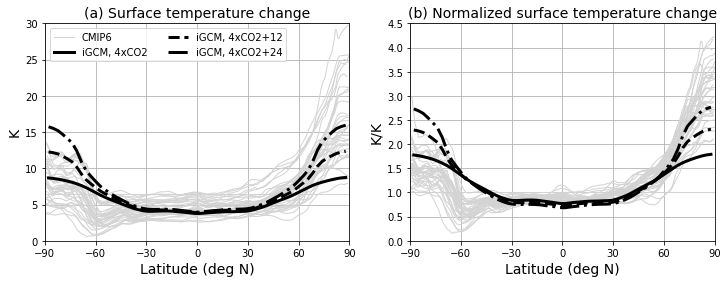

In [10]:
print('If there is an error here make sure "cmip6_data = xr.open_dataset(...)" points to the netCDF you downloaded from http://meteo.mcgill.ca/~mhenry/files/')
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(12, 4)
plt.subplot(1,2,1)
cmip6_data = xr.open_dataset('./cmip6_data/big_ds.nc')
integ_years = (100,149)
for i in range(37):
    try:
        plt.plot(cmip6_data.sel(source_id=cmip6_data.source_id[i]).lat.where(~np.isnan(cmip6_data.sel(source_id=cmip6_data.source_id[i]).ts.sel(experiment_id='abrupt-4xCO2').mean('year'))).dropna(dim='lat'), \
             cmip6_data.sel(source_id=cmip6_data.source_id[i]).ts.sel(experiment_id='abrupt-4xCO2').sel(year=integ_years).mean('year').dropna(dim='lat') - \
             cmip6_data.sel(source_id=cmip6_data.source_id[i]).ts.sel(experiment_id='piControl').sel(year=integ_years).mean('year').dropna(dim='lat'), c='lightgrey', linewidth=1)
    except:
        print(cmip6_data.source_id[i])
i=37
plt.plot(cmip6_data.sel(source_id=cmip6_data.source_id[i]).lat.where(~np.isnan(cmip6_data.sel(source_id=cmip6_data.source_id[i]).ts.sel(experiment_id='abrupt-4xCO2').mean('year'))).dropna(dim='lat'), \
             cmip6_data.sel(source_id=cmip6_data.source_id[i]).ts.sel(experiment_id='abrupt-4xCO2').sel(year=integ_years).mean('year').dropna(dim='lat') - \
             cmip6_data.sel(source_id=cmip6_data.source_id[i]).ts.sel(experiment_id='piControl').sel(year=integ_years).mean('year').dropna(dim='lat'), c='lightgrey', label='CMIP6', linewidth=1)
plt.plot(co2.lat_,co2.sat_lin_diff, 'k', linewidth=3, label='iGCM, 4xCO2')
plt.plot(co2.lat_,co2_HS12.sat_lin_diff, 'k--', linewidth=3, label='iGCM, 4xCO2+12')
plt.plot(co2.lat_,co2_HS24.sat_lin_diff,'k-.', linewidth=3, label='iGCM, 4xCO2+24')
plt.grid()
plt.title('(a) Surface temperature change', **font)
plt.xticks(np.linspace(-90, 90, 7))
plt.xlim([-90,90])
plt.ylim([0,30])
lgd = plt.legend(loc='best',prop={'size': 10},ncol=2)
plt.ylabel('K', **font)
plt.xlabel('Latitude (deg N)', **font)

plt.subplot(1,2,2)
for i in range(38):
    try:
        plt.plot(cmip6_data.sel(source_id=cmip6_data.source_id[i]).lat.where(~np.isnan(cmip6_data.sel(source_id=cmip6_data.source_id[i]).ts.sel(experiment_id='abrupt-4xCO2').mean('year'))).dropna(dim='lat'), \
             (cmip6_data.sel(source_id=cmip6_data.source_id[i]).ts.sel(experiment_id='abrupt-4xCO2').sel(year=integ_years).mean('year').dropna(dim='lat') - \
             cmip6_data.sel(source_id=cmip6_data.source_id[i]).ts.sel(experiment_id='piControl').sel(year=integ_years).mean('year').dropna(dim='lat')) / \
             mean_lat(cmip6_data.sel(source_id=cmip6_data.source_id[i]).lat.where(~np.isnan(cmip6_data.sel(source_id=cmip6_data.source_id[i]).ts.sel(experiment_id='abrupt-4xCO2').mean('year'))).dropna(dim='lat'), \
             (cmip6_data.sel(source_id=cmip6_data.source_id[i]).ts.sel(experiment_id='abrupt-4xCO2').sel(year=integ_years).mean('year').dropna(dim='lat') - \
             cmip6_data.sel(source_id=cmip6_data.source_id[i]).ts.sel(experiment_id='piControl').sel(year=integ_years).mean('year').dropna(dim='lat'))), c='lightgrey', linewidth=1)
    except:
        print(cmip6_data.source_id[i])
plt.plot(co2.lat_,co2.sat_lin_diff/mean_lat(co2.lat_,co2.sat_lin_diff), 'k', linewidth=3)
plt.plot(co2.lat_,co2_HS12.sat_lin_diff/mean_lat(co2.lat_,co2_HS12.sat_lin_diff), 'k--', linewidth=3)
plt.plot(co2.lat_,co2_HS24.sat_lin_diff/mean_lat(co2.lat_,co2_HS24.sat_lin_diff),'k-.', linewidth=3)
plt.grid()
plt.title('(b) Normalized surface temperature change', **font)
plt.xticks(np.linspace(-90, 90, 7))
plt.xlim([-90,90])
plt.ylim([0,4.5])
# lgd = plt.legend(loc='best',prop={'size': 10})
plt.ylabel('K/K', **font)
plt.xlabel('Latitude (deg N)', **font)

plt.savefig('fig1.eps', bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

In [29]:
print(cmip6_data.source_id)

<xarray.DataArray 'source_id' (source_id: 38)>
array(['ACCESS-CM2', 'ACCESS-ESM1-5', 'AWI-CM-1-1-MR', 'BCC-CSM2-MR',
       'BCC-ESM1', 'CAMS-CSM1-0', 'CESM2', 'CESM2-FV2', 'CESM2-WACCM',
       'CESM2-WACCM-FV2', 'CIESM', 'CMCC-CM2-SR5', 'CanESM5', 'E3SM-1-0',
       'EC-Earth3-Veg', 'FGOALS-f3-L', 'FGOALS-g3', 'GFDL-CM4', 'GFDL-ESM4',
       'GISS-E2-1-G', 'GISS-E2-1-H', 'GISS-E2-2-G', 'INM-CM4-8', 'INM-CM5-0',
       'IPSL-CM6A-LR', 'KACE-1-0-G', 'MCM-UA-1-0', 'MIROC6', 'MPI-ESM-1-2-HAM',
       'MPI-ESM1-2-HR', 'MPI-ESM1-2-LR', 'MRI-ESM2-0', 'NESM3', 'NorCPM1',
       'NorESM2-LM', 'NorESM2-MM', 'SAM0-UNICON', 'TaiESM1'], dtype=object)
Coordinates:
  * source_id  (source_id) object 'ACCESS-CM2' 'ACCESS-ESM1-5' ... 'TaiESM1'


# Plot Figure 2 (SCM and idealized GCM comparison)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


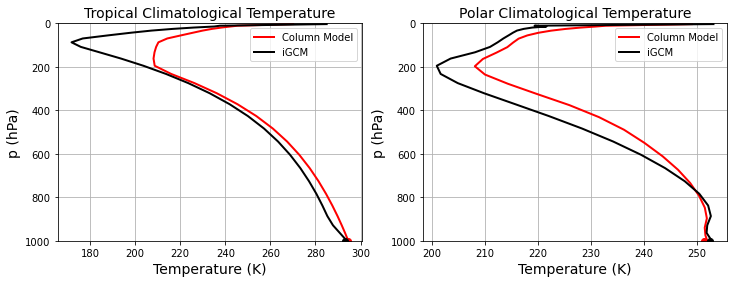

In [11]:
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(12, 4)
plt.subplot(1,2,1)
plt.plot(model_t_ctl.state['Tatm'],model_t_ctl.lev,c='r',label='Column Model',linewidth=2)
plt.plot(model_t_ctl.state['Ts'], 1000, 'ro',markersize=6)
plt.plot(co2_data.temp_300_t,model_t_ctl.lev, 'k', label='iGCM',linewidth=2)
plt.plot(co2_data.ts_300_t, 1000, 'ko',markersize=6)
plt.title('Tropical Climatological Temperature', **font)
plt.xlabel('Temperature (K)', **font)
plt.ylabel('p (hPa)', **font)
lgd =plt.legend(loc='best')
plt.ylim([0,1000])
plt.gca().invert_yaxis()
plt.grid()
plt.subplot(1,2,2)
plt.plot(model_p_ctl.state['Tatm'],model_p_ctl.lev,c='r',label='Column Model',linewidth=2)
plt.plot(model_p_ctl.state['Ts'], 1000, 'ro',markersize=6)
plt.plot(co2_data.temp_300_p,model_t_ctl.lev, 'k', label='iGCM',linewidth=2)
plt.plot(co2_data.ts_300_p, 1000, 'ko',markersize=6)
plt.title('Polar Climatological Temperature', **font)
plt.xlabel('Temperature (K)', **font)
plt.ylabel('p (hPa)', **font)
lgd =plt.legend(loc='best')
plt.ylim([0,1000])
plt.gca().invert_yaxis()
plt.grid()
plt.savefig('fig2.eps', bbox_inches='tight')
plt.show()

# Plot figure 3 (SCM lapse rate changes)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


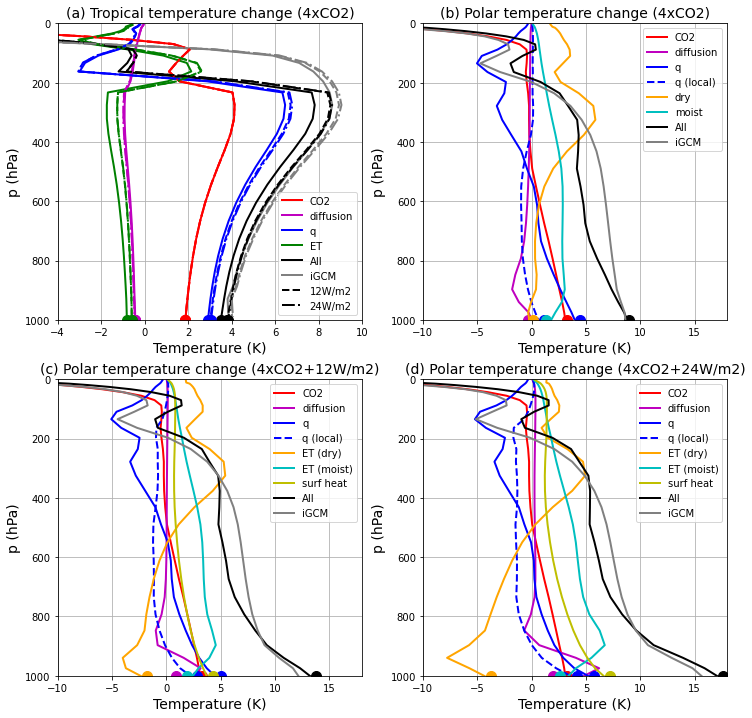

In [12]:
msize=10

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(12,12)
plt.subplot(2,2,1)
plt.plot(model_t_co2.state['Tatm'] - model_t_ctl.state['Tatm'],model_t_ctl.lev,c='r',label='CO2',linewidth=2)
plt.plot(model_t_co2.state['Ts'] - model_t_ctl.state['Ts'], 1000, 'ro',markersize=msize)
plt.plot(model_t_diff.state['Tatm'] - model_t_ctl.state['Tatm'],model_t_ctl.lev,c='m',label='diffusion',linewidth=2)
plt.plot(model_t_diff.state['Ts'] - model_t_ctl.state['Ts'], 1000, 'mo',markersize=msize)
plt.plot(model_t_sh.state['Tatm'] - model_t_ctl.state['Tatm'],model_t_ctl.lev,c='b',label='q',linewidth=2)
plt.plot(model_t_sh.state['Ts'] - model_t_ctl.state['Ts'], 1000, 'bo',markersize=msize)
plt.plot(model_t_ET.state['Tatm'] - model_t_ctl.state['Tatm'],model_t_ctl.lev,c='g',label='ET',linewidth=2)
plt.plot(model_t_ET.state['Ts'] - model_t_ctl.state['Ts'], 1000, 'o', c='g',markersize=msize)
plt.plot(model_t_full.state['Tatm'] - model_t_ctl.state['Tatm'],model_t_ctl.lev,c='k',label='All',linewidth=2)
plt.plot(model_t_full.state['Ts'] - model_t_ctl.state['Ts'], 1000, 'ko',markersize=msize)
plt.plot(co2_data.temp_1200_t-co2_data.temp_300_t,model_t_ctl.lev, 'grey', label='iGCM',linewidth=2)

plt.plot(model_t_co2_HS12.state['Tatm'] - model_t_ctl.state['Tatm'],model_t_ctl.lev,'r--',linewidth=2)
plt.plot(model_t_co2_HS12.state['Ts'] - model_t_ctl.state['Ts'], 1000, 'ro',markersize=msize)
plt.plot(model_t_diff_HS12.state['Tatm'] - model_t_ctl.state['Tatm'],model_t_ctl.lev,'m--',linewidth=2)
plt.plot(model_t_diff_HS12.state['Ts'] - model_t_ctl.state['Ts'], 1000, 'mo',markersize=msize)
plt.plot(model_t_sh_HS12.state['Tatm'] - model_t_ctl.state['Tatm'],model_t_ctl.lev,'b--',linewidth=2)
plt.plot(model_t_sh_HS12.state['Ts'] - model_t_ctl.state['Ts'], 1000, 'bo',markersize=msize)
plt.plot(model_t_ET_HS12.state['Tatm'] - model_t_ctl.state['Tatm'],model_t_ctl.lev,'g--',linewidth=2)
plt.plot(model_t_ET_HS12.state['Ts'] - model_t_ctl.state['Ts'], 1000, 'o', c='g',markersize=msize)
plt.plot(model_t_full_HS12.state['Tatm'] - model_t_ctl.state['Tatm'],model_t_ctl.lev,'k--',label='12W/m2',linewidth=2)
plt.plot(model_t_full_HS12.state['Ts'] - model_t_ctl.state['Ts'], 1000, 'ko',markersize=msize)
plt.plot(HS12_data.temp_1200_t-HS12_data.temp_300_t,model_t_ctl.lev, 'grey', linestyle='--', linewidth=2)

plt.plot(model_t_co2_HS24.state['Tatm'] - model_t_ctl.state['Tatm'],model_t_ctl.lev,'r-.',linewidth=2)
plt.plot(model_t_co2_HS24.state['Ts'] - model_t_ctl.state['Ts'], 1000, 'ro',markersize=msize)
plt.plot(model_t_diff_HS24.state['Tatm'] - model_t_ctl.state['Tatm'],model_t_ctl.lev,'m-.',linewidth=2)
plt.plot(model_t_diff_HS24.state['Ts'] - model_t_ctl.state['Ts'], 1000, 'mo',markersize=msize)
plt.plot(model_t_sh_HS24.state['Tatm'] - model_t_ctl.state['Tatm'],model_t_ctl.lev,'b-.',linewidth=2)
plt.plot(model_t_sh_HS24.state['Ts'] - model_t_ctl.state['Ts'], 1000, 'bo',markersize=msize)
plt.plot(model_t_ET_HS24.state['Tatm'] - model_t_ctl.state['Tatm'],model_t_ctl.lev,'g-.',linewidth=2)
plt.plot(model_t_ET_HS24.state['Ts'] - model_t_ctl.state['Ts'], 1000, 'o', c='g',markersize=msize)
plt.plot(model_t_full_HS24.state['Tatm'] - model_t_ctl.state['Tatm'],model_t_ctl.lev,'k-.',label='24W/m2',linewidth=2)
plt.plot(model_t_full_HS24.state['Ts'] - model_t_ctl.state['Ts'], 1000, 'ko',markersize=msize)
plt.plot(HS24_data.temp_1200_t-HS24_data.temp_300_t,model_t_ctl.lev, 'grey', linestyle='-.', linewidth=2)

plt.title('(a) Tropical temperature change (4xCO2)', **font)
plt.xlabel('Temperature (K)', **font)
plt.ylabel('p (hPa)', **font)
plt.xlim([-4,10])
plt.ylim([0,1000])
lgd =plt.legend(loc='best',fancybox=True, framealpha=0.8)
plt.gca().invert_yaxis()
plt.grid()

plt.subplot(2,2,2)
plt.plot(model_p_co2.state['Tatm'] - model_p_ctl.state['Tatm'],model_p_ctl.lev,c='r',label='CO2',linewidth=2)
plt.plot(model_p_co2.state['Ts'] - model_p_ctl.state['Ts'], 1000, 'ro',markersize=msize)
plt.plot(model_p_diff.state['Tatm'] - model_p_ctl.state['Tatm'],model_p_ctl.lev,c='m',label='diffusion',linewidth=2)
plt.plot(model_p_diff.state['Ts'] - model_p_ctl.state['Ts'], 1000, 'mo',markersize=msize)
plt.plot(model_p_sh.state['Tatm'] - model_p_ctl.state['Tatm'],model_p_ctl.lev,c='b',label='q',linewidth=2)
plt.plot(model_p_sh.state['Ts'] - model_p_ctl.state['Ts'], 1000, 'bo',markersize=msize)
plt.plot(model_p_sh_local.state['Tatm'] - model_p_ctl.state['Tatm'],model_p_ctl.lev,c='b',label='q (local)',linewidth=2,linestyle='--')
plt.plot(model_p_sh_local.state['Ts'] - model_p_ctl.state['Ts'], 1000, 'bo',markersize=msize)
plt.plot(model_p_dry.state['Tatm'] - model_p_ctl.state['Tatm'],model_p_ctl.lev,c='orange',label='dry',linewidth=2)
plt.plot(model_p_dry.state['Ts'] - model_p_ctl.state['Ts'], 1000, 'o', c='orange',markersize=msize)
plt.plot(model_p_moist.state['Tatm'] - model_p_ctl.state['Tatm'],model_p_ctl.lev,c='c',label='moist',linewidth=2)
plt.plot(model_p_moist.state['Ts'] - model_p_ctl.state['Ts'], 1000, 'o', c='c',markersize=msize)
plt.plot(model_p_full.state['Tatm'] - model_p_ctl.state['Tatm'],model_p_ctl.lev,c='k',label='All',linewidth=2)
plt.plot(model_p_full.state['Ts'] - model_p_ctl.state['Ts'], 1000, 'ko',markersize=msize)
plt.plot(co2_data.temp_1200_p-co2_data.temp_300_p,model_p_ctl.lev, 'grey', label='iGCM',linewidth=2)
plt.title('(b) Polar temperature change (4xCO2)', **font)
plt.xlabel('Temperature (K)', **font)
plt.ylabel('p (hPa)', **font)
plt.xlim([-10,18])
plt.ylim([0,1000])
lgd =plt.legend(bbox_to_anchor=(1, 1),fancybox=True, framealpha=0.8)
plt.gca().invert_yaxis()
plt.grid()

plt.subplot(2,2,3)
plt.plot(model_p_co2_HS12.state['Tatm'] - model_p_ctl.state['Tatm'],model_p_ctl.lev,c='r',label='CO2',linewidth=2)
plt.plot(model_p_co2_HS12.state['Ts'] - model_p_ctl.state['Ts'], 1000, 'ro',markersize=msize)
plt.plot(model_p_diff_HS12.state['Tatm'] - model_p_ctl.state['Tatm'],model_p_ctl.lev,c='m',label='diffusion',linewidth=2)
plt.plot(model_p_diff_HS12.state['Ts'] - model_p_ctl.state['Ts'], 1000, 'mo',markersize=msize)
plt.plot(model_p_sh_HS12.state['Tatm'] - model_p_ctl.state['Tatm'],model_p_ctl.lev,c='b',label='q',linewidth=2)
plt.plot(model_p_sh_HS12.state['Ts'] - model_p_ctl.state['Ts'], 1000, 'bo',markersize=msize)
plt.plot(model_p_sh_local_HS12.state['Tatm'] - model_p_ctl.state['Tatm'],model_p_ctl.lev,c='b',label='q (local)',linewidth=2,linestyle='--')
plt.plot(model_p_sh_local_HS12.state['Ts'] - model_p_ctl.state['Ts'], 1000, 'bo',markersize=msize)
plt.plot(model_p_dry_HS12.state['Tatm'] - model_p_ctl.state['Tatm'],model_p_ctl.lev,c='orange',label='ET (dry)',linewidth=2)
plt.plot(model_p_dry_HS12.state['Ts'] - model_p_ctl.state['Ts'], 1000, 'o', c='orange',markersize=msize)
plt.plot(model_p_moist_HS12.state['Tatm'] - model_p_ctl.state['Tatm'],model_p_ctl.lev,c='c',label='ET (moist)',linewidth=2)
plt.plot(model_p_moist_HS12.state['Ts'] - model_p_ctl.state['Ts'], 1000, 'o', c='c',markersize=msize)
plt.plot(model_p_qs_HS12.state['Tatm'] - model_p_ctl.state['Tatm'],model_p_ctl.lev,c='y',label='surf heat',linewidth=2)
plt.plot(model_p_qs_HS12.state['Ts'] - model_p_ctl.state['Ts'], 1000, 'o', c='y',markersize=msize)
plt.plot(model_p_full_HS12.state['Tatm'] - model_p_ctl.state['Tatm'],model_p_ctl.lev,c='k',label='All',linewidth=2)
plt.plot(model_p_full_HS12.state['Ts'] - model_p_ctl.state['Ts'], 1000, 'ko',markersize=msize)
plt.plot(HS12_data.temp_1200_p-HS12_data.temp_300_p,model_p_ctl.lev, 'grey', label='iGCM',linewidth=2)
plt.title('(c) Polar temperature change (4xCO2+12W/m2)', **font)
plt.xlabel('Temperature (K)', **font)
plt.ylabel('p (hPa)', **font)
plt.xlim([-10,18])
plt.ylim([0,1000])
lgd =plt.legend(bbox_to_anchor=(1, 1),fancybox=True, framealpha=0.8)
plt.gca().invert_yaxis()
plt.grid()


plt.subplot(2,2,4)
plt.plot(model_p_co2_HS24.state['Tatm'] - model_p_ctl.state['Tatm'],model_p_ctl.lev,c='r',label='CO2',linewidth=2)
plt.plot(model_p_co2_HS24.state['Ts'] - model_p_ctl.state['Ts'], 1000, 'ro',markersize=msize)
plt.plot(model_p_diff_HS24.state['Tatm'] - model_p_ctl.state['Tatm'],model_p_ctl.lev,c='m',label='diffusion',linewidth=2)
plt.plot(model_p_diff_HS24.state['Ts'] - model_p_ctl.state['Ts'], 1000, 'mo',markersize=msize)
plt.plot(model_p_sh_HS24.state['Tatm'] - model_p_ctl.state['Tatm'],model_p_ctl.lev,c='b',label='q',linewidth=2)
plt.plot(model_p_sh_HS24.state['Ts'] - model_p_ctl.state['Ts'], 1000, 'bo',markersize=msize)
plt.plot(model_p_sh_local_HS24.state['Tatm'] - model_p_ctl.state['Tatm'],model_p_ctl.lev,c='b',label='q (local)',linewidth=2,linestyle='--')
plt.plot(model_p_sh_local_HS24.state['Ts'] - model_p_ctl.state['Ts'], 1000, 'bo',markersize=msize)
plt.plot(model_p_dry_HS24.state['Tatm'] - model_p_ctl.state['Tatm'],model_p_ctl.lev,c='orange',label='ET (dry)',linewidth=2)
plt.plot(model_p_dry_HS24.state['Ts'] - model_p_ctl.state['Ts'], 1000, 'o', c='orange',markersize=msize)
plt.plot(model_p_moist_HS24.state['Tatm'] - model_p_ctl.state['Tatm'],model_p_ctl.lev,c='c',label='ET (moist)',linewidth=2)
plt.plot(model_p_moist_HS24.state['Ts'] - model_p_ctl.state['Ts'], 1000, 'o', c='c',markersize=msize)
plt.plot(model_p_qs_HS24.state['Tatm'] - model_p_ctl.state['Tatm'],model_p_ctl.lev,c='y',label='surf heat',linewidth=2)
plt.plot(model_p_qs_HS24.state['Ts'] - model_p_ctl.state['Ts'], 1000, 'o', c='y',markersize=msize)
plt.plot(model_p_full_HS24.state['Tatm'] - model_p_ctl.state['Tatm'],model_p_ctl.lev,c='k',label='All',linewidth=2)
plt.plot(model_p_full_HS24.state['Ts'] - model_p_ctl.state['Ts'], 1000, 'ko',markersize=msize)
plt.plot(HS24_data.temp_1200_p-HS24_data.temp_300_p,model_p_ctl.lev, 'grey', label='iGCM',linewidth=2)
plt.title('(d) Polar temperature change (4xCO2+24W/m2)', **font)
plt.xlabel('Temperature (K)', **font)
plt.ylabel('p (hPa)', **font)
plt.xlim([-10,18])
plt.ylim([0,1000])
lgd =plt.legend(bbox_to_anchor=(1, 1),fancybox=True, framealpha=0.8)
plt.gca().invert_yaxis()
plt.grid()

plt.savefig('fig3.eps', bbox_inches='tight')
plt.show()

## Data for tables

In [13]:
np.set_printoptions(precision=2)

print('tropics, 4xco2')
print('co2 : ',model_t_co2.state['Ts'] - model_t_ctl.state['Ts'])
print('q: ',model_t_sh.state['Ts'] - model_t_ctl.state['Ts'])
print('ET : ', model_t_ET.state['Ts'] - model_t_ctl.state['Ts'])
print('diff : ', model_t_diff.state['Ts'] - model_t_ctl.state['Ts'])
print('all', model_t_full.state['Ts'] - model_t_ctl.state['Ts'])
print()
print('tropics, 4xCO2+12W/m2')
print('CO2 : ', model_t_co2_HS12.state['Ts'] - model_t_ctl.state['Ts'])
print('q : ', model_t_sh_HS12.state['Ts'] - model_t_ctl.state['Ts'])
print('ET : ', model_t_ET_HS12.state['Ts'] - model_t_ctl.state['Ts'])
print('diff : ', model_t_diff_HS12.state['Ts'] - model_t_ctl.state['Ts'])
print('all : ', model_t_full_HS12.state['Ts'] - model_t_ctl.state['Ts'])
print()
print('tropics, 4xCO2+24W/m2')
print('CO2 : ', model_t_co2_HS24.state['Ts'] - model_t_ctl.state['Ts'])
print('q : ', model_t_sh_HS24.state['Ts'] - model_t_ctl.state['Ts'])
print('ET : ', model_t_ET_HS24.state['Ts'] - model_t_ctl.state['Ts'])
print('diff : ', model_t_diff_HS24.state['Ts'] - model_t_ctl.state['Ts'])
print('all : ', model_t_full_HS24.state['Ts'] - model_t_ctl.state['Ts'])
print()
print()
print('poles, 4xCO2')
print('co2 : ',model_p_co2.state['Ts'] - model_p_ctl.state['Ts'])
print('q: ',model_p_sh.state['Ts'] - model_p_ctl.state['Ts'])
print('ET (dry) : ', model_p_dry.state['Ts'] - model_p_ctl.state['Ts'])
print('ET (moist) : ', model_p_moist.state['Ts'] - model_p_ctl.state['Ts'])
print('diff : ', model_p_diff.state['Ts'] - model_p_ctl.state['Ts'])
print('all : ', model_p_full.state['Ts'] - model_p_ctl.state['Ts'])
print()
print('poles, 4xCO2+12W/m2')
print('co2 : ',model_p_co2_HS12.state['Ts'] - model_p_ctl.state['Ts'])
print('q: ',model_p_sh_HS12.state['Ts'] - model_p_ctl.state['Ts'])
print('ET (dry) : ', model_p_dry_HS12.state['Ts'] - model_p_ctl.state['Ts'])
print('ET (moist) : ', model_p_moist_HS12.state['Ts'] - model_p_ctl.state['Ts'])
print('Surface heat : ', model_p_qs_HS12.state['Ts'] - model_p_ctl.state['Ts'])
print('diff : ', model_p_diff_HS12.state['Ts'] - model_p_ctl.state['Ts'])
print('all : ', model_p_full_HS12.state['Ts'] - model_p_ctl.state['Ts'])
print()
print('poles, 4xCO2+24W/m2')
print('co2 : ',model_p_co2_HS24.state['Ts'] - model_p_ctl.state['Ts'])
print('q: ',model_p_sh_HS24.state['Ts'] - model_p_ctl.state['Ts'])
print('ET (dry) : ', model_p_dry_HS24.state['Ts'] - model_p_ctl.state['Ts'])
print('ET (moist) : ', model_p_moist_HS24.state['Ts'] - model_p_ctl.state['Ts'])
print('Surface heat : ', model_p_qs_HS24.state['Ts'] - model_p_ctl.state['Ts'])
print('diff : ', model_p_diff_HS24.state['Ts'] - model_p_ctl.state['Ts'])
print('all : ', model_p_full_HS24.state['Ts'] - model_p_ctl.state['Ts'])
print()
print()
print('DECOMPOSITION LOCAL/REMOTE DATA')
print()
print('tropics, 4xco2')
print('co2 : ',model_t_co2.state['Ts'] - model_t_ctl.state['Ts'])
print('q (local): ',model_t_sh_local.state['Ts'] - model_t_ctl.state['Ts'])
print('diff: ',model_t_diff.state['Ts'] - model_t_ctl.state['Ts'])
print('local total: ', model_t_co2.state['Ts'] + model_t_sh_local.state['Ts']  + model_t_diff.state['Ts'] - 3* model_t_ctl.state['Ts'])
print('q (remote): ',model_t_sh.state['Ts'] - model_t_sh_local.state['Ts'])
print('ET : ', model_t_ET.state['Ts'] - model_t_ctl.state['Ts'])
print('remote total: ', model_t_sh.state['Ts'] - model_t_sh_local.state['Ts'] + model_t_ET.state['Ts'] - model_t_ctl.state['Ts'])
print('all', model_t_full.state['Ts'] - model_t_ctl.state['Ts'])
print()
print('tropics, 4xCO2+12W/m2')
print('co2 : ',model_t_co2_HS12.state['Ts'] - model_t_ctl.state['Ts'])
print('q (local): ',model_t_sh_local_HS12.state['Ts'] - model_t_ctl.state['Ts'])
print('diff: ',model_t_diff_HS12.state['Ts'] - model_t_ctl.state['Ts'])
print('local total: ', model_t_co2_HS12.state['Ts'] + model_t_sh_local_HS12.state['Ts']  + model_t_diff_HS12.state['Ts'] - 3* model_t_ctl.state['Ts'])
print('q (remote): ',model_t_sh_HS12.state['Ts'] - model_t_sh_local_HS12.state['Ts'])
print('ET : ', model_t_ET_HS12.state['Ts'] - model_t_ctl.state['Ts'])
print('remote total: ', model_t_sh_HS12.state['Ts'] - model_t_sh_local_HS12.state['Ts'] + model_t_ET_HS12.state['Ts'] - model_t_ctl.state['Ts'])
print('all', model_t_full_HS12.state['Ts'] - model_t_ctl.state['Ts'])
print()
print('tropics, 4xCO2+24W/m2')
print('co2 : ',model_t_co2_HS24.state['Ts'] - model_t_ctl.state['Ts'])
print('q (local): ',model_t_sh_local_HS24.state['Ts'] - model_t_ctl.state['Ts'])
print('diff: ',model_t_diff_HS24.state['Ts'] - model_t_ctl.state['Ts'])
print('local total: ', model_t_co2_HS24.state['Ts'] + model_t_sh_local_HS24.state['Ts']  + model_t_diff_HS24.state['Ts'] - 3* model_t_ctl.state['Ts'])
print('q (remote): ',model_t_sh_HS24.state['Ts'] - model_t_sh_local_HS24.state['Ts'])
print('ET : ', model_t_ET_HS24.state['Ts'] - model_t_ctl.state['Ts'])
print('remote total: ', model_t_sh_HS24.state['Ts'] - model_t_sh_local_HS24.state['Ts'] + model_t_ET_HS24.state['Ts'] - model_t_ctl.state['Ts'])
print('all', model_t_full_HS24.state['Ts'] - model_t_ctl.state['Ts'])
print()

print('poles, 4xCO2')
print('co2 : ',model_p_co2.state['Ts'] - model_p_ctl.state['Ts'])
print('q (local): ',model_p_sh_local.state['Ts'] - model_p_ctl.state['Ts'])
print('diff: ',model_p_diff.state['Ts'] - model_p_ctl.state['Ts'])
print('local TOTAL : ', model_p_diff.state['Ts'] + model_p_co2.state['Ts'] + model_p_sh_local.state['Ts'] - 3*model_p_ctl.state['Ts'])
print('q (remote): ',model_p_sh.state['Ts'] - model_p_sh_local.state['Ts'])
print('ET: ',model_p_moist.state['Ts'] + model_p_dry.state['Ts'] - 2*model_p_ctl.state['Ts'])
print('remote (TOTAL) : ', model_p_sh.state['Ts'] - model_p_sh_local.state['Ts'] + model_p_moist.state['Ts'] + model_p_dry.state['Ts'] - 2*model_p_ctl.state['Ts'])
print('all : ', model_p_full.state['Ts'] - model_p_ctl.state['Ts'])
print()
print('poles, 4xCO2+12W/m2')
print('co2 : ',model_p_co2_HS12.state['Ts'] - model_p_ctl.state['Ts'])
print('q (local): ',model_p_sh_local_HS12.state['Ts'] - model_p_ctl.state['Ts'])
print('diff: ',model_p_diff_HS12.state['Ts'] - model_p_ctl.state['Ts'])
print('surface heat: ',model_p_qs_HS12.state['Ts'] - model_p_ctl.state['Ts'])
print('local TOTAL : ', model_p_diff_HS12.state['Ts'] + model_p_qs_HS12.state['Ts'] + model_p_co2_HS12.state['Ts'] + model_p_sh_local_HS12.state['Ts'] - 4*model_p_ctl.state['Ts'])
print('q (remote): ',model_p_sh_HS12.state['Ts'] - model_p_sh_local_HS12.state['Ts'])
print('ET: ',model_p_moist_HS12.state['Ts'] + model_p_dry_HS12.state['Ts'] - 2*model_p_ctl.state['Ts'])
print('remote (TOTAL) : ', model_p_sh_HS12.state['Ts'] - model_p_sh_local_HS12.state['Ts'] + model_p_moist_HS12.state['Ts'] + model_p_dry_HS12.state['Ts'] - 2*model_p_ctl.state['Ts'])
print('all : ', model_p_full_HS12.state['Ts'] - model_p_ctl.state['Ts'])
print()
print('poles, 4xCO2+24W/m2')
print('co2 : ',model_p_co2_HS24.state['Ts'] - model_p_ctl.state['Ts'])
print('q (local): ',model_p_sh_local_HS24.state['Ts'] - model_p_ctl.state['Ts'])
print('surface heat: ',model_p_qs_HS24.state['Ts'] - model_p_ctl.state['Ts'])
print('diff: ',model_p_diff_HS24.state['Ts'] - model_p_ctl.state['Ts'])
print('local TOTAL : ', model_p_diff_HS24.state['Ts'] + model_p_qs_HS24.state['Ts'] + model_p_co2_HS24.state['Ts'] + model_p_sh_local_HS24.state['Ts'] - 4*model_p_ctl.state['Ts'])
print('q (remote): ',model_p_sh_HS24.state['Ts'] - model_p_sh_local_HS24.state['Ts'])
print('ET: ',model_p_moist_HS24.state['Ts'] + model_p_dry_HS24.state['Ts'] - 2*model_p_ctl.state['Ts'])
print('remote (TOTAL) : ', model_p_sh_HS24.state['Ts'] - model_p_sh_local_HS24.state['Ts'] + model_p_moist_HS24.state['Ts'] + model_p_dry_HS24.state['Ts'] - 2*model_p_ctl.state['Ts'])
print('all : ', model_p_full_HS24.state['Ts'] - model_p_ctl.state['Ts'])

tropics, 4xco2
co2 :  [1.87]
q:  [2.91]
ET :  [-0.82]
diff :  [-0.43]
all [3.51]

tropics, 4xCO2+12W/m2
CO2 :  [1.87]
q :  [3.02]
ET :  [-0.59]
diff :  [-0.45]
all :  [3.81]

tropics, 4xCO2+24W/m2
CO2 :  [1.87]
q :  [3.05]
ET :  [-0.59]
diff :  [-0.46]
all :  [3.84]


poles, 4xCO2
co2 :  [3.25]
q:  [4.5]
ET (dry) :  [0.09]
ET (moist) :  [1.36]
diff :  [-0.34]
all :  [8.95]

poles, 4xCO2+12W/m2
co2 :  [3.25]
q:  [5.02]
ET (dry) :  [-1.79]
ET (moist) :  [1.86]
Surface heat :  [4.26]
diff :  [0.85]
all :  [13.78]

poles, 4xCO2+24W/m2
co2 :  [3.25]
q:  [5.77]
ET (dry) :  [-3.78]
ET (moist) :  [2.61]
Surface heat :  [7.19]
diff :  [1.95]
all :  [17.63]


DECOMPOSITION LOCAL/REMOTE DATA

tropics, 4xco2
co2 :  [1.87]
q (local):  [10.34]
diff:  [-0.43]
local total:  [11.78]
q (remote):  [-7.42]
ET :  [-0.82]
remote total:  [-8.24]
all [3.51]

tropics, 4xCO2+12W/m2
co2 :  [1.87]
q (local):  [10.34]
diff:  [-0.45]
local total:  [11.76]
q (remote):  [-7.32]
ET :  [-0.59]
remote total:  [-7.91]
al

# Kernel analysis for figure 4

In [14]:
def saturation_specific_humidity(temp, pfull):
    es = 6.112 * np.exp(17.67 * (temp - 273.15) / (temp - 29.65))  # hPa
    es = xr.DataArray(es, coords=[pfull, temp.lat],
                      dims=['pfull', 'lat'])
    ws = 0.622 * es / (pfull - es)  # Needs to check again??
    qs = ws / (1 + ws)
    qs = xr.DataArray(qs, coords=[pfull, temp.lat],
                    dims=['pfull', 'lat'])
    return qs

def read_kernel(filename, varname):
    ds = xr.open_dataset(filename, decode_times=False)
    pfull = ds.pfull
    lats = ds.lat

    try:
        months = ds.month
    except:
        months = ds.index

    kernel = ds[varname]
    coslats = np.cos(np.deg2rad(lats))

    p_tropopause= 300
    kernel = np.array(kernel.where(kernel.pfull>=p_tropopause))
    kernel[np.isnan(kernel)] = 0.0

    kernel = xr.DataArray(kernel, coords=[months, pfull, lats], dims=['month', 'pfull', 'lat'])
    global_mean_kernel = np.average(kernel.sum(dim='pfull').mean(('month')), weights=coslats, axis=0)
    kernel.attrs['pfull'] = ds.pfull

    print(varname + ': Global mean = ' + str(global_mean_kernel) + ' W/m^2/K')
    kernel.attrs['global_mean'] = global_mean_kernel
    
    return kernel

def calc_planck_feedback_from_kernel(ds_diff, t_kernel, ts_kernel):

    lats = ds_diff.lat
    pfull = ds_diff.pfull
    nlat = len(lats)
    nlev = len(pfull)
    coslats = np.cos(np.deg2rad(lats))

    if 'time' in ds_diff.dims:
        ts_diff = ds_diff['t_surf'].mean(('lon','time'))
    else:
        ts_diff = ds_diff['t_surf'].mean(('lon'))
    
    ts_diff_vert = np.zeros((nlev, nlat), dtype=np.double)
    for nn in range(nlev):
        ts_diff_vert[nn,:] = ts_diff[:]  # uniform warming as surface
        
    ts_diff_vert = xr.DataArray(ts_diff_vert, coords=[pfull, lats],
                     dims=['pfull','lat'])

    tsk = ts_diff_vert * t_kernel
    sfc_response = ts_diff.values * ts_kernel
    
    # Add the surface and air temperature response
    planck_response = tsk.sum(dim='pfull').values + sfc_response
    planck_feedback = planck_response / ts_diff.values

    # Print global average
    planck_response_gm = np.average(planck_response, weights=coslats, axis=0)
    ts_diff_gm = np.average(ts_diff, weights=coslats, axis=0)
    planck_fb_gm = planck_response_gm / ts_diff_gm
    print('Global mean Planck feedback parameter is ' + str(planck_fb_gm) + 'W/m^2/K.')

    return planck_feedback.values  #(month, lat, lon)

def calc_lr_feedback_from_kernel(ds_diff, ds_diff_atm, t_kernel, ts_kernel):

    lats = ds_diff.lat
    pfull = ds_diff.pfull
    nlat = len(lats)
    nlev = len(pfull)
    coslats = np.cos(np.deg2rad(lats))

    if 'time' in ds_diff.dims:
        ts_diff = ds_diff['t_surf'].mean(('lon','time'))
    else:
        ts_diff = ds_diff['t_surf'].mean(('lon'))
    ta_diff = ds_diff_atm['temp']
    
    ts_diff_vert = np.zeros((nlev, nlat), dtype=np.double)
    for nn in range(nlev):
        ts_diff_vert[nn,:] = ts_diff[:]  # uniform warming as surface
    ts_diff_vert = xr.DataArray(ts_diff_vert, coords=[pfull, lats],
                     dims=['pfull','lat'])
    
    del_tair_ts = ta_diff.values - ts_diff_vert.values
    del_tair_ts = xr.DataArray(del_tair_ts, coords=[pfull, lats], 
                            dims=['pfull', 'lat'])
    
    tempk = del_tair_ts * t_kernel
    lapse_rate_feedback = tempk.sum(dim='pfull') / ts_diff.values
    

    # Print global average
    tempk_gm = np.average(tempk.sum(dim='pfull'), weights=coslats, axis=0)
    ts_diff_gm = np.average(ts_diff, weights=coslats, axis=0)
    lapse_rate_fb_gm = tempk_gm / ts_diff_gm
    print('Global mean lapse rate feedback parameter is ' + str(lapse_rate_fb_gm) + 'W/m^2/K.')

    return lapse_rate_feedback.values

def calc_wv_feedback_from_kernel(ds_diff, ds_diff_atm, ds1_atm, wv_kernel):

    lats = ds_diff.lat
    pfull = ds_diff.pfull
    nlat = len(lats)
    nlev = len(pfull)
    coslats = np.cos(np.deg2rad(lats))

    if 'time' in ds_diff.dims:
        ts_diff = ds_diff['t_surf'].mean(('lon','time'))
    else:
        ts_diff = ds_diff['t_surf'].mean(('lon'))
    q_diff = ds_diff_atm['shum_avg']
    q1 = ds1_atm['shum_avg']
    
    qs1 = saturation_specific_humidity(ds1_atm.temp, ds_diff.pfull)
    qs2 = saturation_specific_humidity(ds1_atm.temp + 1.0, ds_diff.pfull)
    
    dT = 1.0
    
    dqs_dT = (qs2.values - qs1.values) / dT # dT is 1K
    rh = q1.values / qs1.values          # assuming RH is fixed when warming
    dq_dT = rh * dqs_dT    
    dlogq_dT = dq_dT / q1.values  # change in the natural log of water vapor using in the kernel calculation
    dlogq = q_diff.values / q1.values    # change in the natural log of the water vapor in perturbed exps

    response = wv_kernel.values * dlogq / dlogq_dT
    wv_feedback = response.sum(axis=0) / ts_diff.values
    
    return wv_feedback

In [14]:
print('If there is an error here make sure the kernels point to the Isca kernels you can download from https://zenodo.org/record/4282681/')

t_lw = read_kernel('./isca_kernels/t_lw_kernel.nc','t_lw_kernel')
t_lw = t_lw.mean('month')

t_sw = read_kernel('./isca_kernels/t_sw_kernel.nc','t_sw_kernel')
t_sw = t_sw.mean('month')
ds1 = xr.open_dataset('./iGCM_data/idealised_moist_AM2rad_albedo/300ppm/surf_ave.nc', decode_times=False)
from scipy import interpolate
f = interpolate.interp2d(t_lw.lat,t_lw.pfull,t_lw+t_sw)
t_lw_interp = xr.DataArray(f(ds1.lat,ds1.pfull), coords=[ds1.pfull, ds1.lat],
                     dims=['pfull','lat'])

kernel_ts_lw = xr.open_dataset('./isca_kernels/sfc_ts_lw_kernel.nc')
ts_lw = kernel_ts_lw.lw_kernel.mean('index')

wv_lw = read_kernel('./isca_kernels/wv_lw_kernel.nc','wv_lw_kernel')
wv_lw = wv_lw.mean('month')

wv_sw = read_kernel('./isca_kernels/wv_sw_kernel.nc','wv_sw_kernel')
wv_sw = wv_sw.mean('month')

f = interpolate.interp2d(t_lw.lat,t_lw.pfull,wv_lw+wv_sw)
wv_lw_interp = xr.DataArray(f(ds1.lat,ds1.pfull), coords=[ds1.pfull, ds1.lat],
                     dims=['pfull','lat'])


fixedSST = xr.open_dataset('./iGCM_data/idealised_moist_AM2rad_fixedsst_SCM/1200ppm/surf_ave.nc',decode_times=False)
F_co2 =  -fixedSST.olr.mean(('lon','time')) +ds1.olr.mean(('lon','time'))
forcing_CO2_lwgrid = F_co2.values

If there is an error here make sure the kernels point to the aquaplanet kernels netCDF files you downloaded from http://meteo.mcgill.ca/~mhenry/files/
t_lw_kernel: Global mean = 1.6402287703145335 W/m^2/K
t_sw_kernel: Global mean = 0.0017955482708946952 W/m^2/K
wv_lw_kernel: Global mean = -1.4431530515888393 W/m^2/K
wv_sw_kernel: Global mean = 0.36040077160485023 W/m^2/K


In [15]:
lat_lw = ds1.lat
masks = [lat_lw>-10,lat_lw<10]
mask_trop_pm = masks[0] & masks[1]
masks = [lat_lw<-80,lat_lw>80]
mask_poles_pm = masks[0] | masks[1]

ds1 = xr.open_dataset('./iGCM_data/idealised_moist_AM2rad_albedo/300ppm/surf_ave.nc', decode_times=False)
ds2 = xr.open_dataset('./iGCM_data/idealised_moist_AM2rad_albedo/1200ppm/surf_ave.nc', decode_times=False)
ds1_atm = xr.open_dataset('./iGCM_data/idealised_moist_AM2rad_albedo/300ppm/day_ave.nc', decode_times=False)
ds2_atm = xr.open_dataset('./iGCM_data/idealised_moist_AM2rad_albedo/1200ppm/day_ave.nc', decode_times=False)
ds_diff = ds2 - ds1
ds_diff_atm = ds2_atm - ds1_atm

PFB = calc_planck_feedback_from_kernel(ds_diff, t_lw_interp, ts_lw)
LFB_CO2 = calc_lr_feedback_from_kernel(ds_diff,ds_diff_atm, t_lw_interp, ts_lw)
WVFB_CO2 = calc_wv_feedback_from_kernel(ds_diff,ds_diff_atm, ds1_atm, wv_lw_interp)

MSE_ctl_ = ds1.swdn_toa.mean(('lon','time'))-ds1.swup_toa.mean(('lon','time'))-ds1.olr.mean(('lon','time'))
MSE_CO2_ = ds2.swdn_toa.mean(('lon','time'))-ds2.swup_toa.mean(('lon','time'))-ds2.olr.mean(('lon','time'))
MSE_ctl = MSE_ctl_.values
MSE_CO2 = MSE_CO2_.values

dTs_CO2_lwgrid = ds_diff.t_surf.mean(('lon','time')).values
lat_lw = ds1.lat.values

PFB_mean = mean_lat(ds1.lat,PFB).values
F_CO2_cont = forcing_CO2_lwgrid / PFB_mean
MSE_CO2_cont = -(MSE_CO2-MSE_ctl)/ PFB_mean
LFB_CO2_cont = -LFB_CO2*dTs_CO2_lwgrid/PFB_mean
WVFB_CO2_cont = -WVFB_CO2*dTs_CO2_lwgrid/PFB_mean
PFB_CO2_cont = -(PFB-PFB_mean)*dTs_CO2_lwgrid/PFB_mean
res_CO2 = dTs_CO2_lwgrid - F_CO2_cont - MSE_CO2_cont - LFB_CO2_cont - WVFB_CO2_cont - PFB_CO2_cont

PFB_CO2_poles=mean_lat(lat_lw[mask_poles_pm],PFB_CO2_cont[mask_poles_pm])
PFB_CO2_trop=mean_lat(lat_lw[mask_trop_pm],PFB_CO2_cont[mask_trop_pm])
LFB_CO2_poles=mean_lat(lat_lw[mask_poles_pm],LFB_CO2_cont[mask_poles_pm])
LFB_CO2_trop=mean_lat(lat_lw[mask_trop_pm],LFB_CO2_cont[mask_trop_pm])
WVFB_CO2_poles=mean_lat(lat_lw[mask_poles_pm],WVFB_CO2_cont[mask_poles_pm])
WVFB_CO2_trop=mean_lat(lat_lw[mask_trop_pm],WVFB_CO2_cont[mask_trop_pm])
MSE_CO2_poles=mean_lat(lat_lw[mask_poles_pm],MSE_CO2_cont[mask_poles_pm])
MSE_CO2_trop=mean_lat(lat_lw[mask_trop_pm],MSE_CO2_cont[mask_trop_pm])
F_CO2_poles=mean_lat(lat_lw[mask_poles_pm],F_CO2_cont[mask_poles_pm])
F_CO2_trop=mean_lat(lat_lw[mask_trop_pm],F_CO2_cont[mask_trop_pm])
res_CO2_poles=mean_lat(lat_lw[mask_poles_pm],res_CO2[mask_poles_pm])
res_CO2_trop=mean_lat(lat_lw[mask_trop_pm],res_CO2[mask_trop_pm])

Global mean Planck feedback parameter is 3.2459145904501185W/m^2/K.
Global mean lapse rate feedback parameter is 0.5673752477068223W/m^2/K.


In [16]:
ds1 = xr.open_dataset('./iGCM_data/idealised_moist_AM2rad_albedo/300ppm/surf_ave.nc', decode_times=False)
ds2 = xr.open_dataset('./iGCM_data/idealised_moist_AM2rad_albedo/1200ppm_HS12/surf_ave.nc', decode_times=False)
ds1_atm = xr.open_dataset('./iGCM_data/idealised_moist_AM2rad_albedo/300ppm/day_ave.nc', decode_times=False)
ds2_atm = xr.open_dataset('./iGCM_data/idealised_moist_AM2rad_albedo/1200ppm_HS12/day_ave.nc', decode_times=False)
ds_diff = ds2.mean('time') - ds1.mean('time')
ds_diff_atm = ds2_atm - ds1_atm

PFB = calc_planck_feedback_from_kernel(ds_diff, t_lw_interp, ts_lw)
LFB_CO2 = calc_lr_feedback_from_kernel(ds_diff,ds_diff_atm, t_lw_interp, ts_lw)
WVFB_CO2 = calc_wv_feedback_from_kernel(ds_diff,ds_diff_atm, ds1_atm, wv_lw_interp)

forcing_SHS = np.zeros_like(lat_lw)
forcing_SHS[lat_lw<=-80]=12
forcing_SHS[lat_lw>=80]=12

MSE_ctl_ = ds1.swdn_toa.mean(('lon','time'))-ds1.swup_toa.mean(('lon','time'))-ds1.olr.mean(('lon','time'))
MSE_CO2_ = ds2.swdn_toa.mean(('lon','time'))-ds2.swup_toa.mean(('lon','time'))-ds2.olr.mean(('lon','time'))
MSE_ctl = MSE_ctl_.values
MSE_CO2 = MSE_CO2_.values
MSE_CO2 = MSE_CO2+forcing_SHS

dTs_CO2_lwgrid = ds_diff.t_surf.mean(('lon')).values
lat_lw = ds1.lat.values

PFB_mean = mean_lat(ds1.lat,PFB).values
F_CO2_cont = forcing_CO2_lwgrid / PFB_mean
MSE_CO2_cont = -(MSE_CO2-MSE_ctl)/ PFB_mean
LFB_CO2_cont = -LFB_CO2*dTs_CO2_lwgrid/PFB_mean
WVFB_CO2_cont = -WVFB_CO2*dTs_CO2_lwgrid/PFB_mean
PFB_CO2_cont = -(PFB-PFB_mean)*dTs_CO2_lwgrid/PFB_mean
forcing_SHS_cont = forcing_SHS/PFB_mean
res_CO2 = dTs_CO2_lwgrid - F_CO2_cont - MSE_CO2_cont - LFB_CO2_cont - WVFB_CO2_cont - PFB_CO2_cont - forcing_SHS_cont

PFB_CO2_poles_12=mean_lat(lat_lw[mask_poles_pm],PFB_CO2_cont[mask_poles_pm])
PFB_CO2_trop_12=mean_lat(lat_lw[mask_trop_pm],PFB_CO2_cont[mask_trop_pm])
LFB_CO2_poles_12=mean_lat(lat_lw[mask_poles_pm],LFB_CO2_cont[mask_poles_pm])
LFB_CO2_trop_12=mean_lat(lat_lw[mask_trop_pm],LFB_CO2_cont[mask_trop_pm])
WVFB_CO2_poles_12=mean_lat(lat_lw[mask_poles_pm],WVFB_CO2_cont[mask_poles_pm])
WVFB_CO2_trop_12=mean_lat(lat_lw[mask_trop_pm],WVFB_CO2_cont[mask_trop_pm])
MSE_CO2_poles_12=mean_lat(lat_lw[mask_poles_pm],MSE_CO2_cont[mask_poles_pm])
MSE_CO2_trop_12=mean_lat(lat_lw[mask_trop_pm],MSE_CO2_cont[mask_trop_pm])
F_CO2_poles_12=mean_lat(lat_lw[mask_poles_pm],F_CO2_cont[mask_poles_pm])
F_CO2_trop_12=mean_lat(lat_lw[mask_trop_pm],F_CO2_cont[mask_trop_pm])
forcing_SHS_poles_12=mean_lat(lat_lw[mask_poles_pm],forcing_SHS_cont[mask_poles_pm])
forcing_SHS_trop_12=0
res_CO2_poles_12=mean_lat(lat_lw[mask_poles_pm],res_CO2[mask_poles_pm])
res_CO2_trop_12=mean_lat(lat_lw[mask_trop_pm],res_CO2[mask_trop_pm])

Global mean Planck feedback parameter is 3.214474963643885W/m^2/K.
Global mean lapse rate feedback parameter is 0.4660261924783499W/m^2/K.


In [17]:
ds1 = xr.open_dataset('./iGCM_data/idealised_moist_AM2rad_albedo/300ppm/surf_ave.nc', decode_times=False)
ds2 = xr.open_dataset('./iGCM_data/idealised_moist_AM2rad_albedo/1200ppm_HS24/surf_ave.nc', decode_times=False)
ds1_atm = xr.open_dataset('./iGCM_data/idealised_moist_AM2rad_albedo/300ppm/day_ave.nc', decode_times=False)
ds2_atm = xr.open_dataset('./iGCM_data/idealised_moist_AM2rad_albedo/1200ppm_HS24/day_ave.nc', decode_times=False)
ds_diff = ds2.mean('time') - ds1.mean('time')
ds_diff_atm = ds2_atm - ds1_atm

PFB = calc_planck_feedback_from_kernel(ds_diff, t_lw_interp, ts_lw)
LFB_CO2 = calc_lr_feedback_from_kernel(ds_diff,ds_diff_atm, t_lw_interp, ts_lw)
WVFB_CO2 = calc_wv_feedback_from_kernel(ds_diff,ds_diff_atm, ds1_atm, wv_lw_interp)

forcing_SHS = np.zeros_like(lat_lw)
forcing_SHS[lat_lw<=-80]=24
forcing_SHS[lat_lw>=80]=24

MSE_ctl_ = ds1.swdn_toa.mean(('lon','time'))-ds1.swup_toa.mean(('lon','time'))-ds1.olr.mean(('lon','time'))
MSE_CO2_ = ds2.swdn_toa.mean(('lon','time'))-ds2.swup_toa.mean(('lon','time'))-ds2.olr.mean(('lon','time'))
MSE_ctl = MSE_ctl_.values
MSE_CO2 = MSE_CO2_.values
MSE_CO2 = MSE_CO2+forcing_SHS

dTs_CO2_lwgrid = ds_diff.t_surf.mean(('lon')).values
lat_lw = ds1.lat.values

PFB_mean = mean_lat(ds1.lat,PFB).values
F_CO2_cont = forcing_CO2_lwgrid / PFB_mean
MSE_CO2_cont = -(MSE_CO2-MSE_ctl)/ PFB_mean
LFB_CO2_cont = -LFB_CO2*dTs_CO2_lwgrid/PFB_mean
WVFB_CO2_cont = -WVFB_CO2*dTs_CO2_lwgrid/PFB_mean
PFB_CO2_cont = -(PFB-PFB_mean)*dTs_CO2_lwgrid/PFB_mean
forcing_SHS_cont = forcing_SHS/PFB_mean
res_CO2 = dTs_CO2_lwgrid - F_CO2_cont - MSE_CO2_cont - LFB_CO2_cont - WVFB_CO2_cont - PFB_CO2_cont - forcing_SHS_cont

PFB_CO2_poles_24=mean_lat(lat_lw[mask_poles_pm],PFB_CO2_cont[mask_poles_pm])
PFB_CO2_trop_24=mean_lat(lat_lw[mask_trop_pm],PFB_CO2_cont[mask_trop_pm])
LFB_CO2_poles_24=mean_lat(lat_lw[mask_poles_pm],LFB_CO2_cont[mask_poles_pm])
LFB_CO2_trop_24=mean_lat(lat_lw[mask_trop_pm],LFB_CO2_cont[mask_trop_pm])
WVFB_CO2_poles_24=mean_lat(lat_lw[mask_poles_pm],WVFB_CO2_cont[mask_poles_pm])
WVFB_CO2_trop_24=mean_lat(lat_lw[mask_trop_pm],WVFB_CO2_cont[mask_trop_pm])
MSE_CO2_poles_24=mean_lat(lat_lw[mask_poles_pm],MSE_CO2_cont[mask_poles_pm])
MSE_CO2_trop_24=mean_lat(lat_lw[mask_trop_pm],MSE_CO2_cont[mask_trop_pm])
F_CO2_poles_24=mean_lat(lat_lw[mask_poles_pm],F_CO2_cont[mask_poles_pm])
F_CO2_trop_24=mean_lat(lat_lw[mask_trop_pm],F_CO2_cont[mask_trop_pm])
forcing_SHS_poles_24=mean_lat(lat_lw[mask_poles_pm],forcing_SHS_cont[mask_poles_pm])
forcing_SHS_trop_24=0
res_CO2_poles_24=mean_lat(lat_lw[mask_poles_pm],res_CO2[mask_poles_pm])
res_CO2_trop_24=mean_lat(lat_lw[mask_trop_pm],res_CO2[mask_trop_pm])

Global mean Planck feedback parameter is 3.18762415254745W/m^2/K.
Global mean lapse rate feedback parameter is 0.3824984599203628W/m^2/K.


# Plot figure 4 (TOA / SCM method comparison)

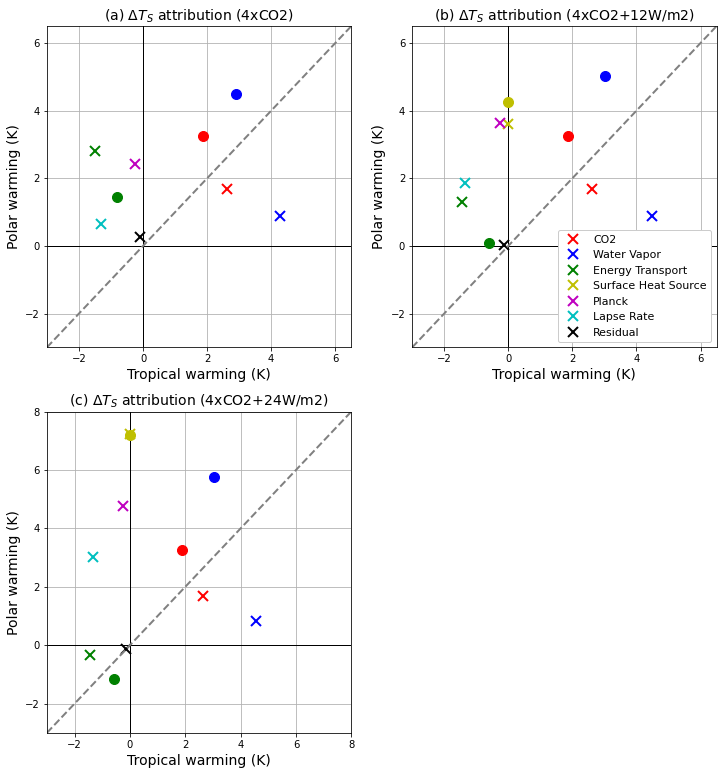

In [18]:
ms=10
mew=2
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(12, 13)
plt.subplot(2,2,1)
plt.hlines(0, -3, 7,linewidth=1, color='k')
plt.vlines(0, -3, 7,linewidth=1, color='k')
plt.plot(F_CO2_trop,F_CO2_poles, 'x', color='r', ms=ms, mew=mew, label='CO2')
plt.plot(WVFB_CO2_trop,WVFB_CO2_poles, 'x', color='b', ms=ms, mew=mew, label='Water Vapor')
plt.plot(MSE_CO2_trop,MSE_CO2_poles, 'x', color='g', ms=ms, mew=mew, label='Energy Transport')
plt.plot(PFB_CO2_trop, PFB_CO2_poles, 'x', color='m', ms=ms, mew=mew, label='Planck')
plt.plot(LFB_CO2_trop,LFB_CO2_poles, 'x', color='c', ms=ms, mew=mew, label='Lapse Rate')
# plt.plot(forcing_SHS_trop,forcing_SHS_poles, 'x', color='r', ms=ms, mew=mew, label='SHS')
plt.plot(res_CO2_trop,res_CO2_poles, 'x', color='k', ms=ms, mew=mew, label='Residual')
plt.plot(model_t_co2.state['Ts'] - model_t_ctl.state['Ts'], model_p_co2.state['Ts'] - model_p_ctl.state['Ts'], 'o', color='r',markersize=msize)
plt.plot(model_t_sh.state['Ts']- model_t_ctl.state['Ts'], model_p_sh.state['Ts']- model_p_ctl.state['Ts'], 'bo',markersize=msize)
plt.plot(model_t_ET.state['Ts'] - model_t_ctl.state['Ts'], model_p_moist.state['Ts'] + model_p_dry.state['Ts'] - 2*model_p_ctl.state['Ts'], 'o', c='g',markersize=msize)
# plt.plot(0, model_HS12_surf.state['Ts'] - model.state['Ts'], 'o', c='r',markersize=msize)
plt.plot([-3, 6.5], [-3, 6.5], color='grey', linestyle='--', linewidth=2)
plt.xlim([-3,6.5])
plt.ylim([-3,6.5])
# lgd = plt.legend(bbox_to_anchor=(1.45, 1),numpoints = 1)
# plt.legend(loc='lower right',numpoints = 1)
plt.grid()
plt.title('(a) $\Delta T_S$ attribution (4xCO2)', **font)
plt.xlabel('Tropical warming (K)', **font)
plt.ylabel('Polar warming (K)', **font)

plt.subplot(2,2,2)
plt.hlines(0, -3, 7,linewidth=1, color='k')
plt.vlines(0, -3, 7,linewidth=1, color='k')
plt.plot(F_CO2_trop_12,F_CO2_poles_12, 'x', color='r', ms=ms, mew=mew, label='CO2')
plt.plot(WVFB_CO2_trop_12,WVFB_CO2_poles_12, 'x', color='b', ms=ms, mew=mew, label='Water Vapor')
plt.plot(MSE_CO2_trop_12,MSE_CO2_poles_12, 'x', color='g', ms=ms, mew=mew, label='Energy Transport')
plt.plot(forcing_SHS_trop_12,forcing_SHS_poles_12, 'x', color='y', ms=ms, mew=mew, label='Surface Heat Source')
plt.plot(PFB_CO2_trop_12, PFB_CO2_poles_12, 'x', color='m', ms=ms, mew=mew, label='Planck')
plt.plot(LFB_CO2_trop_12,LFB_CO2_poles_12, 'x', color='c', ms=ms, mew=mew, label='Lapse Rate')
plt.plot(res_CO2_trop_12,res_CO2_poles_12, 'x', color='k', ms=ms, mew=mew, label='Residual')
plt.plot(model_t_co2_HS12.state['Ts'] - model_t_ctl.state['Ts'], model_p_co2_HS12.state['Ts'] - model_p_ctl.state['Ts'], 'o', color='r',markersize=msize)
plt.plot(model_t_sh_HS12.state['Ts']- model_t_ctl.state['Ts'], model_p_sh_HS12.state['Ts']- model_p_ctl.state['Ts'], 'bo',markersize=msize)
plt.plot(model_t_ET_HS12.state['Ts'] - model_t_ctl.state['Ts'], model_p_moist_HS12.state['Ts'] + model_p_dry_HS12.state['Ts'] - 2*model_p_ctl.state['Ts'], 'o', c='g',markersize=msize)
plt.plot(0, model_p_qs_HS12.state['Ts']- model_p_ctl.state['Ts'], 'o', c='y',markersize=msize)
plt.plot([-3, 6.5], [-3, 6.5], color='grey', linestyle='--', linewidth=2)
plt.xlim([-3,6.5])
plt.ylim([-3,6.5])
# lgd = plt.legend(bbox_to_anchor=(1.45, 1),numpoints = 1)
# plt.legend(loc='lower right',numpoints = 1)
plt.legend(loc='best',prop={'size': 11},framealpha=1)
plt.grid()
plt.title('(b) $\Delta T_S$ attribution (4xCO2+12W/m2)', **font)
plt.xlabel('Tropical warming (K)', **font)
plt.ylabel('Polar warming (K)', **font)

plt.subplot(2,2,3)
plt.hlines(0, -3, 9.5,linewidth=1, color='k')
plt.vlines(0, -3, 9.5,linewidth=1, color='k')
plt.plot(F_CO2_trop_24,F_CO2_poles_24, 'x', color='r', ms=ms, mew=mew, label='CO2')
plt.plot(WVFB_CO2_trop_24,WVFB_CO2_poles_24, 'x', color='b', ms=ms, mew=mew, label='Water Vapor')
plt.plot(MSE_CO2_trop_24,MSE_CO2_poles_24, 'x', color='g', ms=ms, mew=mew, label='Energy Transport')
plt.plot(forcing_SHS_trop_24,forcing_SHS_poles_24, 'x', color='y', ms=ms, mew=mew, label='Surface Heat Source')
plt.plot(PFB_CO2_trop_24, PFB_CO2_poles_24, 'x', color='m', ms=ms, mew=mew, label='Planck')
plt.plot(LFB_CO2_trop_24,LFB_CO2_poles_24, 'x', color='c', ms=ms, mew=mew, label='Lapse Rate')
plt.plot(res_CO2_trop_24,res_CO2_poles_24, 'x', color='k', ms=ms, mew=mew, label='Residual')
plt.plot(model_t_co2_HS24.state['Ts'] - model_t_ctl.state['Ts'], model_p_co2_HS24.state['Ts'] - model_p_ctl.state['Ts'], 'o', color='r',markersize=msize)
plt.plot(model_t_sh_HS24.state['Ts']- model_t_ctl.state['Ts'], model_p_sh_HS24.state['Ts']- model_p_ctl.state['Ts'], 'bo',markersize=msize)
plt.plot(model_t_ET_HS24.state['Ts'] - model_t_ctl.state['Ts'], model_p_moist_HS24.state['Ts'] + model_p_dry_HS24.state['Ts'] - 2*model_p_ctl.state['Ts'], 'o', c='g',markersize=msize)
plt.plot(0, model_p_qs_HS24.state['Ts']- model_p_ctl.state['Ts'], 'o', c='y',markersize=msize)
plt.plot([-3, 8], [-3, 8], color='grey', linestyle='--', linewidth=2)
plt.xlim([-3,8])
plt.ylim([-3,8])
# lgd = plt.legend(bbox_to_anchor=(1.65, 1),numpoints = 1)
# plt.legend(loc='lower right',numpoints = 1)
plt.grid()
plt.title('(c) $\Delta T_S$ attribution (4xCO2+24W/m2)', **font)
plt.xlabel('Tropical warming (K)', **font)
plt.ylabel('Polar warming (K)', **font)
plt.savefig('fig4.eps', bbox_inches='tight')
plt.show()

In [19]:
MSE_CO2_poles_12

1.3073136

# Supplementary figures

# Supplementary Figure 1 (Albedo)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


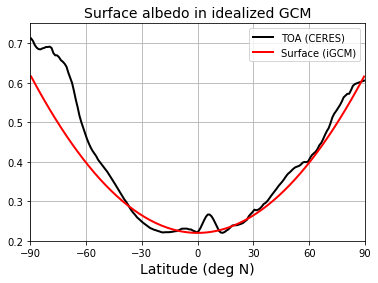

In [20]:
albedo_CERES_ = netCDF4.Dataset('./CERES_albedo.nc')
lat_ = albedo_CERES_.variables['lat'][:]
sol_ = np.mean(np.mean(albedo_CERES_.variables['solar_clim'][:],0),1)
toasw_ = np.mean(np.mean(albedo_CERES_.variables['toa_sw_all_clim'][:],0),1)
plt.plot(lat_,toasw_/sol_,'k',linewidth=2, label='TOA (CERES)')

CERES_albedo_poly = 0.22 + 0.4*(lat_/90)**2
plt.plot(lat_,CERES_albedo_poly,'r',linewidth=2, label='Surface (iGCM)')

# albedo_value=0.22
# higher_albedo = 0.62
# albedo_exp = 2
# mima_albedo = albedo_value + (higher_albedo-albedo_value)*(lat_/90.)**albedo_exp
# plt.plot(lat_,mima_albedo,'b',linewidth=2, label='mima')

plt.legend(loc='best',prop={'size': 12})
plt.title('Surface albedo in idealized GCM', **font)
plt.xlabel('Latitude (deg N)', **font)
plt.xticks(np.linspace(-90, 90, 7))
plt.xlim([-90,90])
plt.ylim([0.2,0.75])
plt.legend(loc='best')
plt.grid()
plt.savefig('figS1.eps')
plt.show()

## Supplementary figure 2 (temperature tendencies from GCM prescribed in SCM)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


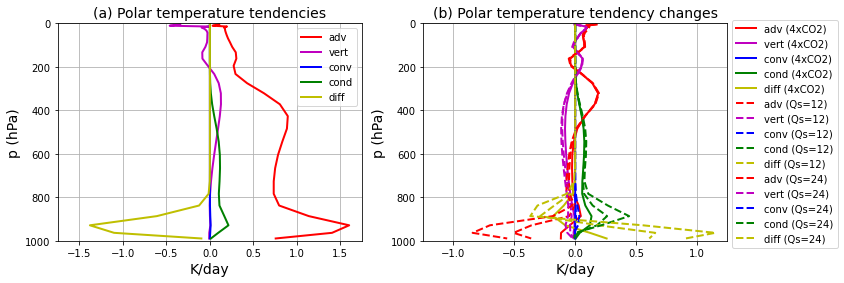

In [21]:
from scipy.interpolate import interp1d
def mydiv_w(field):
    field_conv = np.zeros((co2.sig_.shape[0],field.shape[1]))
    for j in range(co2.lat_.shape[0]):
        funct = interp1d(co2.sig_,field[:,j],fill_value='extrapolate')
        field_conv[:,j]=np.diff(funct(co2.sig_stag))/np.diff(co2.sig_stag)
    return field_conv

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(12, 4)
plt.subplot(1,2,1)
plt.plot(3600*24*co2_data.dt_adv_300_p,co2.sig_*1000,c='r',label='adv',linewidth=2)
plt.plot(3600*24*plot_pole(-co2.f_lin.variables['w_avg'][:]*mydiv_w(co2.temp_lin),co2.lat_,80),co2.sig_*1000,c='m',label='vert',linewidth=2)
plt.plot(3600*24*co2_data.dt_conv_300_p,co2.sig_*1000,c='b',label='conv',linewidth=2)
plt.plot(3600*24*co2_data.dt_cond_300_p,co2.sig_*1000,c='g',label='cond',linewidth=2)
plt.plot(3600*24*co2_data.dt_diff_300_p,co2.sig_*1000,c='y',label='diff',linewidth=2)
plt.title('(a) Polar temperature tendencies', **font)
plt.xlabel('K/day', **font)
plt.ylabel('p (hPa)', **font)
plt.ylim([0,1000])
plt.xlim([-1.75,1.75])
lgd =plt.legend(loc='best')
plt.gca().invert_yaxis()
plt.grid()
plt.subplot(1,2,2)
plt.plot(3600*24*(co2_data.dt_adv_1200_p-co2_data.dt_adv_300_p),co2.sig_*1000,c='r',label='adv (4xCO2)',linewidth=2)
plt.plot(3600*24*plot_pole(-co2.f_lin_14xCO2.variables['w_avg'][:]*mydiv_w(co2.temp_lin_14xCO2)+co2.f_lin.variables['w_avg'][:]*mydiv_w(co2.temp_lin),co2.lat_,80),co2.sig_*1000,c='m',label='vert (4xCO2)',linewidth=2)
plt.plot(3600*24*(co2_data.dt_conv_1200_p-co2_data.dt_conv_300_p),co2.sig_*1000,c='b',label='conv (4xCO2)',linewidth=2)
plt.plot(3600*24*(co2_data.dt_cond_1200_p-co2_data.dt_cond_300_p),co2.sig_*1000,c='g',label='cond (4xCO2)',linewidth=2)
plt.plot(3600*24*(co2_data.dt_diff_1200_p-co2_data.dt_diff_300_p),co2.sig_*1000,c='y',label='diff (4xCO2)',linewidth=2)
plt.plot(3600*24*(HS12_data.dt_adv_1200_p-HS12_data.dt_adv_300_p),co2.sig_*1000,c='r',label='adv (Qs=12)',linewidth=2,linestyle='--')
plt.plot(3600*24*plot_pole(-co2_HS12.f_lin_14xCO2.variables['w_avg'][:]*mydiv_w(co2_HS12.temp_lin_14xCO2)+co2_HS12.f_lin.variables['w_avg'][:]*mydiv_w(co2_HS12.temp_lin),co2.lat_,80),co2.sig_*1000,c='m',label='vert (Qs=12)',linewidth=2,linestyle='--')
plt.plot(3600*24*(HS12_data.dt_conv_1200_p-HS12_data.dt_conv_300_p),co2.sig_*1000,c='b',label='conv (Qs=12)',linewidth=2,linestyle='--')
plt.plot(3600*24*(HS12_data.dt_cond_1200_p-HS12_data.dt_cond_300_p),co2.sig_*1000,c='g',label='cond (Qs=12)',linewidth=2,linestyle='--')
plt.plot(3600*24*(HS12_data.dt_diff_1200_p-HS12_data.dt_diff_300_p),co2.sig_*1000,c='y',label='diff (Qs=12)',linewidth=2,linestyle='--')
plt.plot(3600*24*(HS24_data.dt_adv_1200_p-HS24_data.dt_adv_300_p),co2.sig_*1000,c='r',label='adv (Qs=24)',linewidth=2,linestyle='--')
plt.plot(3600*24*plot_pole(-co2_HS24.f_lin_14xCO2.variables['w_avg'][:]*mydiv_w(co2_HS24.temp_lin_14xCO2)+co2_HS24.f_lin.variables['w_avg'][:]*mydiv_w(co2_HS24.temp_lin),co2.lat_,80),co2.sig_*1000,c='m',label='vert (Qs=24)',linewidth=2,linestyle='--')
plt.plot(3600*24*(HS24_data.dt_conv_1200_p-HS24_data.dt_conv_300_p),co2.sig_*1000,c='b',label='conv (Qs=24)',linewidth=2,linestyle='--')
plt.plot(3600*24*(HS24_data.dt_cond_1200_p-HS24_data.dt_cond_300_p),co2.sig_*1000,c='g',label='cond (Qs=24)',linewidth=2,linestyle='--')
plt.plot(3600*24*(HS24_data.dt_diff_1200_p-HS24_data.dt_diff_300_p),co2.sig_*1000,c='y',label='diff (Qs=24)',linewidth=2,linestyle='--')
plt.title('(b) Polar temperature tendency changes', **font)
plt.xlabel('K/day', **font)
plt.ylabel('p (hPa)', **font)
plt.xlim([-1.25,1.25])
plt.ylim([0,1000])
lgd =plt.legend(bbox_to_anchor=(1, 1.04))
plt.gca().invert_yaxis()
plt.grid()
plt.savefig('figS2.eps', bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

## Supplementary figure 3 (analog of figure 2 with latitude bounds set to 20 and 60).

In [22]:
print_GCM_surf_values(co2,20,60)
print_GCM_SW_values(co2,20,60)

Pole control
Net LW : 85.6512298894202
Net SW : 80.87273425737538
Difference : 4.778495632044809
Flux t : -9.208904874389214
Flux lhe : 4.58405752095428
Tropics Control
Net LW : 92.53235875690646
Net SW : 241.5391250490635
Difference : -149.00676629215704
Flux t : 14.32064680503808
Flux lhe : 134.9897568991497
Tropical albedo = 0.22615329244591376
Polar albedo = 0.4714834497394035
TOA SW down (insol) in tropics : 409.656643226391
TOA SW down (insol) in high lat : 199.02764907000878


Opened data from /home/links/mh920/.conda/envs/anal_env/lib/python3.6/site-packages/climlab/radiation/data/ozone/apeozone_cam3_5_54.nc
Opened data from /home/links/mh920/.conda/envs/anal_env/lib/python3.6/site-packages/climlab/radiation/data/ozone/apeozone_cam3_5_54.nc


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


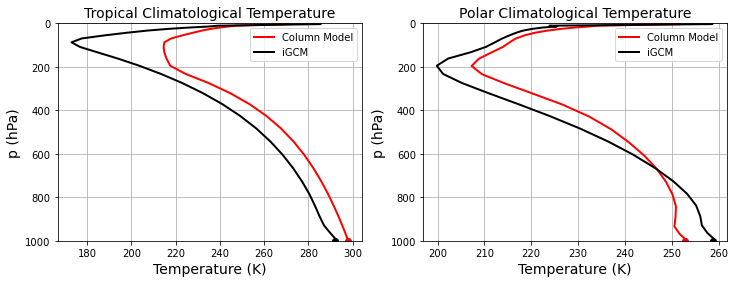

In [23]:
co2_data_bounds = gcm_data(co2,60,20)
model_p_ctl_bounds = run_column(co2_data_bounds.dt_adv_300_p+co2_data_bounds.dt_cond_300_p+co2_data_bounds.dt_diff_300_p, co2_data_bounds.sh_300_p, co2_data_bounds.p_pole, co2_lev=3e-4, insol=199, alb=0.47,surf_forc=5/climlab.utils.heat_capacity.ocean(1))
model_t_ctl_bounds = run_column(co2_data_bounds.dt_adv_300_t+co2_data_bounds.dt_cond_300_t+co2_data_bounds.dt_diff_300_t, co2_data_bounds.sh_300_t, co2_data_bounds.p_trop, co2_lev=3e-4, insol=410, alb=0.22,surf_forc=0/climlab.utils.heat_capacity.ocean(1))

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(12, 4)
plt.subplot(1,2,1)
plt.plot(model_t_ctl_bounds.state['Tatm'],model_t_ctl_bounds.lev,c='r',label='Column Model',linewidth=2)
plt.plot(model_t_ctl_bounds.state['Ts'], 1000, 'ro',markersize=6)
plt.plot(co2_data_bounds.temp_300_t,model_t_ctl.lev, 'k', label='iGCM',linewidth=2)
plt.plot(co2_data_bounds.ts_300_t, 1000, 'ko',markersize=6)
plt.title('Tropical Climatological Temperature', **font)
plt.xlabel('Temperature (K)', **font)
plt.ylabel('p (hPa)', **font)
lgd =plt.legend(loc='best')
plt.ylim([0,1000])
plt.gca().invert_yaxis()
plt.grid()
plt.subplot(1,2,2)
plt.plot(model_p_ctl_bounds.state['Tatm'],model_p_ctl_bounds.lev,c='r',label='Column Model',linewidth=2)
plt.plot(model_p_ctl_bounds.state['Ts'], 1000, 'ro',markersize=6)
plt.plot(co2_data_bounds.temp_300_p,model_t_ctl.lev, 'k', label='iGCM',linewidth=2)
plt.plot(co2_data_bounds.ts_300_p, 1000, 'ko',markersize=6)
plt.title('Polar Climatological Temperature', **font)
plt.xlabel('Temperature (K)', **font)
plt.ylabel('p (hPa)', **font)
lgd =plt.legend(loc='best')
plt.ylim([0,1000])
plt.gca().invert_yaxis()
plt.grid()
plt.savefig('figS3.eps', bbox_inches='tight')
plt.show()

## Supplementary figure 4 (relative humidity)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


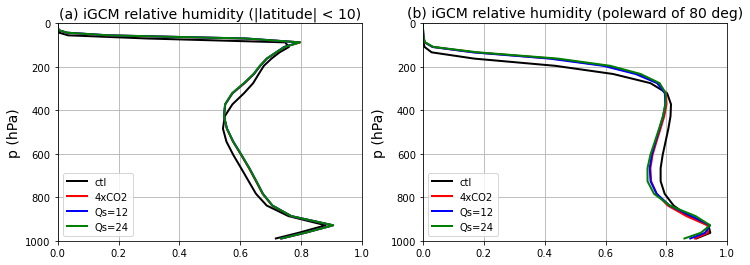

In [24]:
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(12, 4)
plt.subplot(1,2,1)
plt.plot(plot_eq(co2.f_lin.variables['rhum_avg'][:],co2.lat_,10),co2.sig_*1000,'k', label='ctl',linewidth=2)
plt.plot(plot_eq(co2.f_lin_14xCO2.variables['rhum_avg'][:],co2.lat_,10),co2.sig_*1000,'r', label='4xCO2',linewidth=2)
plt.plot(plot_eq(co2_HS12.f_lin_14xCO2.variables['rhum_avg'][:],co2.lat_,10),co2.sig_*1000,'b', label='Qs=12',linewidth=2)
plt.plot(plot_eq(co2_HS24.f_lin_14xCO2.variables['rhum_avg'][:],co2.lat_,10),co2.sig_*1000,'g', label='Qs=24',linewidth=2)
plt.title('(a) iGCM relative humidity (|latitude| < 10)', **font)
plt.ylabel('p (hPa)', **font)
plt.xlim([0,1])
lgd =plt.legend(loc='best')
plt.ylim([0,1000])
plt.gca().invert_yaxis()
plt.grid()
plt.subplot(1,2,2)
plt.plot(plot_pole(co2.f_lin.variables['rhum_avg'][:],co2.lat_,80),co2.sig_*1000,'k', label='ctl',linewidth=2)
plt.plot(plot_pole(co2.f_lin_14xCO2.variables['rhum_avg'][:],co2.lat_,80),co2.sig_*1000,'r', label='4xCO2',linewidth=2)
plt.plot(plot_pole(co2_HS12.f_lin_14xCO2.variables['rhum_avg'][:],co2.lat_,80),co2.sig_*1000,'b', label='Qs=12',linewidth=2)
plt.plot(plot_pole(co2_HS24.f_lin_14xCO2.variables['rhum_avg'][:],co2.lat_,80),co2.sig_*1000,'g', label='Qs=24',linewidth=2)
plt.title('(b) iGCM relative humidity (poleward of 80 deg)', **font)
plt.ylabel('p (hPa)', **font)
plt.xlim([0,1])
lgd =plt.legend(loc='best')
plt.ylim([0,1000])
plt.gca().invert_yaxis()
plt.grid()
plt.savefig('figS4.eps', bbox_inches='tight')
plt.show()

## Supplementary figures 5-8 (checking fixed RH SCM)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


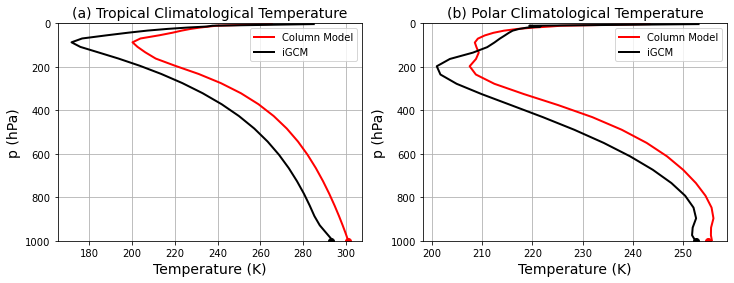

In [25]:
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(12, 4)
plt.subplot(1,2,1)
plt.plot(model_t_ctl_RH.state['Tatm'],model_t_ctl_RH.lev,c='r',label='Column Model',linewidth=2)
plt.plot(model_t_ctl_RH.state['Ts'], 1000, 'ro',markersize=6)
plt.plot(co2_data.temp_300_t,model_t_ctl.lev, 'k', label='iGCM',linewidth=2)
plt.plot(co2_data.ts_300_t, 1000, 'ko',markersize=6)
plt.title('(a) Tropical Climatological Temperature', **font)
plt.xlabel('Temperature (K)', **font)
plt.ylabel('p (hPa)', **font)
plt.ylim([0,1000])
lgd =plt.legend(loc='best')
plt.gca().invert_yaxis()
plt.grid()
plt.subplot(1,2,2)
plt.plot(model_p_ctl_RH.state['Tatm'],model_p_ctl_RH.lev,c='r',label='Column Model',linewidth=2)
plt.plot(model_p_ctl_RH.state['Ts'], 1000, 'ro',markersize=6)
plt.plot(co2_data.temp_300_p,model_p_ctl.lev, 'k', label='iGCM',linewidth=2)
plt.plot(co2_data.ts_300_p, 1000, 'ko',markersize=6)
plt.title('(b) Polar Climatological Temperature', **font)
plt.xlabel('Temperature (K)', **font)
plt.ylabel('p (hPa)', **font)
plt.ylim([0,1000])
lgd =plt.legend(loc='best')
plt.gca().invert_yaxis()
plt.grid()
plt.savefig('figS5.eps', bbox_inches='tight')
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


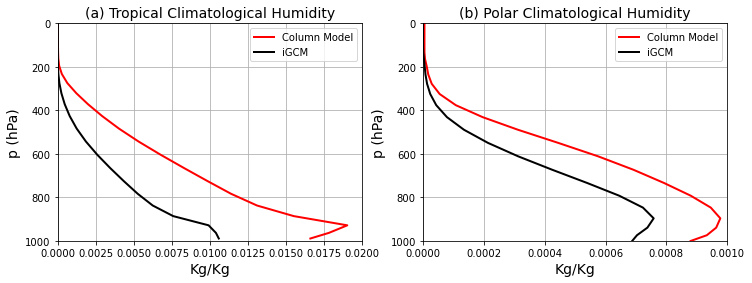

In [26]:
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(12, 4)
plt.subplot(1,2,1)
plt.plot(model_t_ctl_RH.q,model_t_ctl_RH.lev,c='r',label='Column Model',linewidth=2)
plt.plot(co2_data.sh_300_t,model_t_ctl.lev, 'k', label='iGCM',linewidth=2)
plt.title('(a) Tropical Climatological Humidity', **font)
plt.xlabel('Kg/Kg', **font)
plt.ylabel('p (hPa)', **font)
plt.xlim([0,0.02])
plt.ylim([0,1000])
lgd =plt.legend(loc='best')
plt.gca().invert_yaxis()
plt.grid()
plt.subplot(1,2,2)
plt.plot(model_p_ctl_RH.q,model_p_ctl_RH.lev,c='r',label='Column Model',linewidth=2)
plt.plot(co2_data.sh_300_p,model_p_ctl.lev, 'k', label='iGCM',linewidth=2)
plt.title('(b) Polar Climatological Humidity', **font)
plt.xlabel('Kg/Kg', **font)
plt.ylabel('p (hPa)', **font)
lgd =plt.legend(loc='best')
plt.grid()
plt.xlim([0,0.001])
plt.ylim([0,1000])
plt.gca().invert_yaxis()
plt.savefig('figS6.eps', bbox_inches='tight')
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


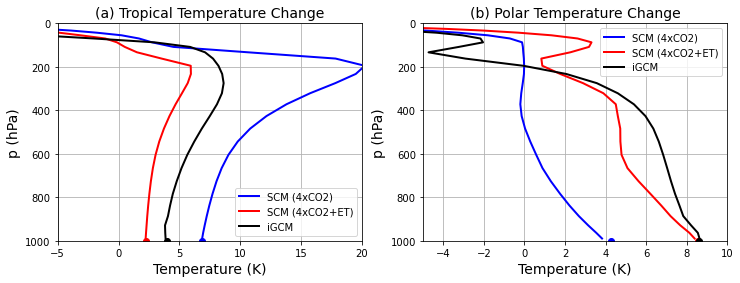

In [27]:
masks = [co2.lat_>-30,co2.lat_<30]
mask = masks[0] & masks[1]
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(12, 4)
plt.subplot(1,2,1)
plt.plot(model_t_co2_RH.Tatm-model_t_ctl_RH.Tatm,model_t_ctl_RH.lev,c='b',
         label='SCM (4xCO2)',linewidth=2)
plt.plot(model_t_co2_RH.Ts-model_t_ctl_RH.Ts, 1000, 'bo',markersize=6)
plt.plot(model_t_full_RH.Tatm-model_t_ctl_RH.Tatm,model_t_ctl_RH.lev,c='r',
         label='SCM (4xCO2+ET)',linewidth=2)
plt.plot(model_t_full_RH.Ts-model_t_ctl_RH.Ts, 1000, 'ro',markersize=6)
plt.plot(plot_eq(co2.temp_lin_diff,co2.lat_,10),co2.sig_*1000, 'k', label='iGCM',linewidth=2)
plt.plot(mean_lat(co2.lat_[mask],co2.sat_lin_diff[mask]), 1000, 'ko',markersize=6)
plt.title('(a) Tropical Temperature Change', **font)
plt.xlabel('Temperature (K)', **font)
plt.ylabel('p (hPa)', **font)
plt.xlim([-5,20])
plt.ylim([0,1000])
lgd =plt.legend(loc='best')
plt.gca().invert_yaxis()
plt.grid()
plt.subplot(1,2,2)
plt.plot(model_p_co2_RH.Tatm-model_p_ctl_RH.Tatm,model_t_ctl_RH.lev,c='b',
         label='SCM (4xCO2)',linewidth=2)
plt.plot(model_p_co2_RH.Ts-model_p_ctl_RH.Ts, 1000, 'bo',markersize=6)
plt.plot(model_p_full_RH.Tatm-model_p_ctl_RH.Tatm,model_t_ctl_RH.lev,c='r',
         label='SCM (4xCO2+ET)',linewidth=2)
plt.plot(model_p_full_RH.Ts-model_p_ctl_RH.Ts, 1000, 'ro',markersize=6)
plt.plot(plot_pole(co2.temp_lin_diff,co2.lat_,80),co2.sig_*1000, 'k', label='iGCM',linewidth=2)
plt.plot(mean_lat(co2.lat_[co2.lat_>80],co2.sat_lin_diff[co2.lat_>80]), 1000, 'ko',markersize=6)
plt.title('(b) Polar Temperature Change', **font)
plt.xlabel('Temperature (K)', **font)
plt.ylabel('p (hPa)', **font)
plt.xlim([-5,10])
plt.ylim([0,1000])
lgd =plt.legend(loc='best')
plt.gca().invert_yaxis()
plt.grid()
plt.savefig('figS7.eps', bbox_inches='tight')
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


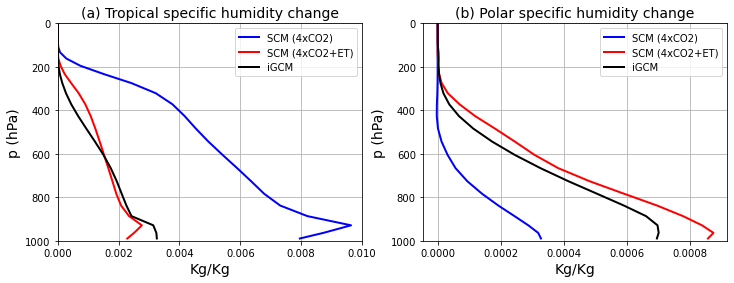

In [28]:
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(12, 4)
plt.subplot(1,2,1)
plt.plot(model_t_co2_RH.q-model_t_ctl_RH.q,model_t_ctl_RH.lev,c='b',
         label='SCM (4xCO2)',linewidth=2)
plt.plot(model_t_full_RH.q-model_t_ctl_RH.q,model_t_ctl_RH.lev,c='r',
         label='SCM (4xCO2+ET)',linewidth=2)
plt.plot(plot_eq(co2.q_lin_diff,co2.lat_,10),co2.sig_*1000, 'k', label='iGCM',linewidth=2)
plt.title('(a) Tropical specific humidity change', **font)
plt.xlabel('Kg/Kg', **font)
plt.ylabel('p (hPa)', **font)
plt.ylim([0,1000])
plt.xlim([0,0.01])
# plt.xlim([-5,15])
lgd =plt.legend(loc='best')
plt.gca().invert_yaxis()
plt.grid()
plt.subplot(1,2,2)
plt.plot(model_p_co2_RH.q-model_p_ctl_RH.q,model_t_ctl_RH.lev,c='b',
         label='SCM (4xCO2)',linewidth=2)
plt.plot(model_p_full_RH.q-model_p_ctl_RH.q,model_t_ctl_RH.lev,c='r',
         label='SCM (4xCO2+ET)',linewidth=2)
plt.plot(plot_pole(co2.q_lin_diff,co2.lat_,80),co2.sig_*1000, 'k', label='iGCM',linewidth=2)
plt.title('(b) Polar specific humidity change', **font)
plt.xlabel('Kg/Kg', **font)
plt.ylabel('p (hPa)', **font)
# plt.xlim([-5,15])
lgd =plt.legend(loc='best')
plt.grid()
plt.ylim([0,1000])
plt.gca().invert_yaxis()
plt.savefig('figS8.eps', bbox_inches='tight')
plt.show()